## Import Libraries

In [240]:
# import libraries
import glob
import pandas as pd
import warnings
from tqdm import tqdm
import os
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
import matplotlib.ticker as ticker
import utils as ut
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import binomtest
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
import math

## Functions

In [241]:
def get_csv_data_as_dataframe(data_path, Animal_ID, protocols, data_type, unique_value_threshold=10):
    """
    Args:
        data_path (str): path to the data folder
        Animal_ID (str): animal ID
        protocol (str): protocol name
        data_type (str): data type (e.g. 'Trial_Summary', 'Detected_Licks')
        unique_value_threshold (int): maximum number of unique values to retrieve per column

    Returns:
        multiindex_df (pd.DataFrame): MultiIndex DataFrame containing information for each CSV file
    """

    subject_folders = glob.glob(f"{data_path}/{Animal_ID}/*")
    # protocol_folders = [folder for folder in subject_folders if f"{protocol}_{Animal_ID}" in folder]
    # protocol_folders = [folder for folder in subject_folders if protocol in folder]
    protocol_folders = [folder for folder in subject_folders if any(value in folder for value in protocols)]



    if not protocol_folders:
        warnings.warn(f"{Animal_ID}: protocol folders empty")
        return pd.DataFrame()

    data = []
    for folder in tqdm(protocol_folders, position=0, leave=True, desc=f'Processing {Animal_ID}'):
        folder_files = glob.glob(f"{folder}/**/{data_type}*.csv", recursive=True)
        for file_path in folder_files:
            try:
                df = pd.read_csv(file_path)
                # Check if the DataFrame is empty (only headers, no data rows)
                if df.empty:
                    # If the DataFrame is empty, skip this file and continue with the next one
                    continue
                # Shorten the file path
                short_path = '/'.join(file_path.split('/')[-3:])
                file_size = os.path.getsize(file_path)
                creation_timestamp = os.path.getctime(file_path)
                creation_time_human = datetime.datetime.fromtimestamp(creation_timestamp).strftime('%Y-%m-%d %H:%M:%S')
                num_rows = len(df)
                num_columns = len(df.columns)  # Number of columns in the dataframe

                for column in df.columns:
                    unique_types = df[column].dropna().apply(lambda x: type(x).__name__).unique()[:unique_value_threshold]
                    unique_values = df[column].dropna().unique()[:unique_value_threshold]
                    num_missing = df[column].isnull().sum()
                        # When Info_Type is unique_types and the Data column is empty, fill it with NaN
                    # if 'unique_types' in df['Info_Type'].values and df[column].isnull().all():
                    #     df.loc[df['Info_Type'] == 'unique_types', 'Data'] = np.nan
                    # Calculate summary statistics only for numerical columns
                    if df[column].dtype in [np.int64, np.float64]:
                        summary_stats = df[column].describe().to_dict()
                        column_data = {
                            'unique_types': ', '.join(unique_types),
                            'unique_values': ', '.join(map(str, unique_values)),
                            'num_missing': num_missing,
                            **summary_stats
                        }
                    else:
                        column_data = {
                            'unique_types': ', '.join(unique_types),
                            'unique_values': ', '.join(map(str, unique_values)),
                            'num_missing': num_missing
                        }
                    for info_type, value in column_data.items():
                        data.append((short_path, column, info_type, value))

                # Add file metadata including creation timestamp and number of columns
                data.append((short_path, 'File_Metadata', 'file_size', file_size))
                data.append((short_path, 'File_Metadata', 'num_rows', num_rows))
                data.append((short_path, 'File_Metadata', 'num_columns', num_columns))  # Adding num_columns
                data.append((short_path, 'File_Metadata', 'creation_timestamp', creation_time_human))

            except Exception as e:
                warnings.warn(f"Error processing file {file_path}: {e}")

    # Creating MultiIndex DataFrame
    multiindex_df = pd.DataFrame(data, columns=['File_Path', 'Column', 'Info_Type', 'Data'])
    multiindex_df.set_index(['File_Path', 'Column', 'Info_Type'], inplace=True)

    return multiindex_df

def get_animal_data(data_path, Animal_ID, protocols, data_type):
    """
    Args:
        data_path (str): path to the data folder
        Animal_ID (str): animal ID
        protocol (str): protocol name
        data_type (str): data type (e.g. 'Trial_Summary', 'Detected_Licks')
    Returns:
        animal_df (pd.DataFrame): dataframe containing all the data for the animal
    """

    subject_folders = glob.glob(data_path + Animal_ID +'/*') 
    # protocol_folders = list(filter(lambda x: protocol in x, subject_folders)) 
    protocol_folders = [folder for folder in subject_folders if any(value in folder for value in protocols)]


    if len(protocol_folders) == 0:
        warnings.warn(f"{Animal_ID}: all_folders empty")
        return 0

    sessions_data = []
    for folder in tqdm(protocol_folders, position=0, leave=True, desc = 'Processing ' + Animal_ID ):  
        folder_files = glob.glob(folder +'/**/'+data_type +'*.csv', recursive = True)
        for file in folder_files:
            try:
                session_df = pd.read_csv(file)

                # # Explicitly cast columns with all-bool values to boolean type
                # for col in session_df.columns:
                #     if session_df[col].dtype == 'object' and set(session_df[col].unique()) <= {True, False, None}:
                #         session_df[col] = session_df[col].astype('bool')

                date_pattern = r'\d{4}_\d{1,2}_\d{1,2}'
                date = re.search(date_pattern, file).group(0)
                date_obj = datetime.datetime.strptime(date, '%Y_%m_%d')
                formatted_date = date_obj.strftime('%Y/%m/%d')
                session_df.insert(0, 'Date', formatted_date)
                session_df['File_ID'] = file  # Add file identifier
                sessions_data.append(session_df)
            except pd.errors.EmptyDataError:
                pass

        animal_df = pd.concat(sessions_data, axis=0, ignore_index=True)
        # Create a list of columns for sorting
        sort_columns = ['Date']

        # Check which of the columns ('Trial_End_Time' or 'Time') exists in the DataFrame
        if 'Trial_End_Time' in animal_df.columns:
            sort_columns.append('Trial_End_Time')
        elif 'Time' in animal_df.columns:
            sort_columns.append('Time')

        # Sort the DataFrame by the determined columns
        animal_df = animal_df.sort_values(by=sort_columns)

        date_list = []
        for date in animal_df.Date.unique():
            date_df = animal_df[animal_df.Date == date].reset_index(drop=True)
            date_list.append(date_df)
            
        try:
            animal_df = pd.concat(date_list, axis=0, ignore_index=True)
        except ValueError:
            # animal_df = pd.DataFrame()
            print(f"Error concatenating date_list for {Animal_ID}")
            continue


    return animal_df

def add_block_column(df, participant_col, datetime_col, trial_end_time, trial_col):
    """
    Adds a block column to the dataframe based on the start of each trial for each participant.
    
    Parameters:
    - df (pd.DataFrame): Input dataframe containing the trials.
    - participant_col (str): Column name for the participant identifier.
    - datetime_col (str): Column name for the datetime of each entry.
    - trial_end_time (str): Column name for the trial end time.
    - trial_col (str): Column name indicating the trial number.
    
    Returns:
    - pd.DataFrame: The dataframe with an added block column.
    """
    # Sort the dataframe as required
    df_sorted = df.sort_values(by=[participant_col, datetime_col, trial_end_time])
    # Identify the start of a new block
    df_sorted['block'] = (df_sorted[trial_col] == 1).astype(int).groupby(df_sorted[participant_col]).cumsum()

    return df_sorted

def calculate_average_run_length(df, participant_col, block_col, category_col = 'Category'):
    # Convert the contingency column to a categorical type
    df[category_col] = df[category_col].astype('category')

    # Function to calculate the average run length for each group
    def average_run_length(group):
        cat_codes = group[category_col].cat.codes
        diffs = cat_codes.diff().ne(0)
        runs = diffs.cumsum()
        run_counts = runs.value_counts()
        # Calculate the average run length
        avg_run_length = run_counts.mean()
        return avg_run_length

    # Group by participant and block columns, then apply the average_run_length function
    avg_run_length_df = df.groupby([participant_col, block_col]).apply(average_run_length).reset_index()

    # Rename columns for clarity
    avg_run_length_df.columns = [participant_col, block_col, 'Average_Category_Run_Length']
    
    return avg_run_length_df

## Get CSV Info

In [242]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocols = ['SOUND_CAT', 'AUDITORY_DISCRIMINATION', 'TONES', 'PSYCH', 'AMPS', 'SC_DISC', 'AMP_MOD']
data_type = 'Trial_Summary'

Animal_List = ['QP032', 'QP033', 'QP034', 'QP049', 'QP050', 'QP051',
               'QP062', 'QP063', 'QP070', 'QP071', 'QP079',  'QP081', 'QP082']               


# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_csv_info_SC.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        csv_info = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    csv_info = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_csv_data_as_dataframe(data_path,
                                             animal, 
                                             protocols,
                                             data_type)
            csv_info = pd.concat([csv_info, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(csv_info, f)

In [78]:
csv_info_reset = csv_info.reset_index()
# whenever there is a NaN in the Data column and the Info_Type is unique_types, fill it with NaN
csv_info_reset.loc[csv_info_reset['Info_Type'] == 'unique_types', 'Data'] = csv_info_reset.loc[csv_info_reset['Info_Type'] == 'unique_types', 'Data'].replace('', np.nan)

In [79]:
# Step 1: Identify each unique value in the 'Column' column
unique_columns = csv_info_reset['Column'].unique()

analysis_results = {}

for column in unique_columns:
    column_df = csv_info_reset[csv_info_reset['Column'] == column]
    unique_file_paths_count = column_df['File_Path'].nunique()

    # Breakdown by data type
    data_types = column_df[column_df['Info_Type'] == 'unique_types']['Data'].unique()
    data_types_breakdown = {}
    for data_type in data_types:
        # Start by handling the NaN case
        if pd.isna(data_type):
            data_type_count = column_df[(column_df['Info_Type'] == 'unique_types') & (column_df['Data'].isna())]['File_Path'].nunique()
            data_types_breakdown['nan'] = {
                'count': data_type_count
            }
        elif data_type in ['int', 'float', 'double']:
            # Extract numeric values
            numeric_values = column_df[column_df['Info_Type'] == 'unique_values']['Data']
            # Splitting string of numbers into individual numeric values
            numeric_values = numeric_values.dropna().apply(lambda x: pd.Series(str(x).split(', '))).stack().reset_index(drop=True)
            numeric_values = numeric_values.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
            data_type_count = column_df[(column_df['Info_Type'] == 'unique_types') & (column_df['Data'] == data_type)]['File_Path'].nunique()
            # Descriptive summary
            descriptive_summary = numeric_values.describe()
            # Unique values (up to 10)
            unique_values = numeric_values.unique()[:10]
            data_types_breakdown[data_type] = {
                'count': data_type_count,
                'summary': descriptive_summary,
                'unique_values': unique_values
            }
        else:
            # For non-numeric types, list all unique values
            unique_values = column_df[column_df['Info_Type'] == 'unique_values']['Data'].unique()
            data_type_count = column_df[(column_df['Info_Type'] == 'unique_types') & (column_df['Data'] == data_type)]['File_Path'].nunique()
            data_types_breakdown[data_type] = {
                'count': data_type_count,
                'unique_values': unique_values
            }

    # Add the results to the dictionary
    analysis_results[column] = {
        'unique_file_paths_count': unique_file_paths_count,
        'data_types_breakdown': data_types_breakdown
    }

# Convert the dictionary to a DataFrame for better visualization
analysis_results_df = pd.DataFrame.from_dict(analysis_results, orient='index')
analysis_results_df.reset_index(inplace=True)
analysis_results_df.rename(columns={'index': 'Column'}, inplace=True)

In [80]:
analysis_results_df

,Column,unique_file_paths_count,data_types_breakdown
0,Animal_ID,1832,"{'str': {'count': 1832, 'unique_values': ['QP0..."
1,TrialNumber,1832,"{'int': {'count': 1830, 'summary': [18044.0, 5..."
2,Tone,1760,"{'float': {'count': 675, 'summary': [6341.0, 8..."
3,FirstLick,1826,"{'int': {'count': 1820, 'summary': [4007.0, 1...."
4,Correct,1810,"{'bool': {'count': 1809, 'unique_values': ['Fa..."
5,Rewside,1810,"{'int': {'count': 1801, 'summary': [3594.0, -7..."
6,TrialOutcome,1810,"{'int': {'count': 1800, 'summary': [5278.0, -1..."
7,AbortTrial,1810,"{'bool': {'count': 1808, 'unique_values': ['Fa..."
8,CorrectCount,1821,"{'int': {'count': 1807, 'summary': [17642.0, -..."
9,GoCueDur,1810,"{'str': {'count': 1810, 'unique_values': ['00:..."


In [81]:
analysis_results_df[analysis_results_df['Column'] == 'Stage'].data_types_breakdown.values[0]

{'str': {'count': 96,
  'unique_values': array(['Stage_4', 'Stage_2', '4', 'Stage_3', 'Stage_1', '4.0', '3', '1',
         '2', '2.0', '3.0'], dtype=object)},
 'int': {'count': 143,
  'summary': count    149.000000
  mean       3.838926
  std        0.604791
  min        1.000000
  25%        4.000000
  50%        4.000000
  75%        4.000000
  max        4.000000
  dtype: float64,
  'unique_values': array([4., 3., 1., 2.])},
 'float': {'count': 6,
  'summary': count    149.000000
  mean       3.838926
  std        0.604791
  min        1.000000
  25%        4.000000
  50%        4.000000
  75%        4.000000
  max        4.000000
  dtype: float64,
  'unique_values': array([4., 3., 1., 2.])}}

In [82]:
csv_info_reset[csv_info_reset.Column == 'Stim_Relative'].File_Path.unique()[0]

'QP032/SOUND_CAT_CONT_QP032_2023_4_12/Trial_Summary2023-04-12T08_48_08.csv'

In [83]:
# Break execution here
raise Exception('Break execution here')

Exception: Break execution here

In [243]:
protocols = ['SOUND_CAT', 'AUDITORY_DISCRIMINATION', 'TONES', 'PSYCH', 'AMPS', 'SC_DISC', 'AMP_MOD']


## Fetch data

In [244]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
# protocols = ['SOUND_CAT', 'AUDITORY_DISCRIMINATION', 'TONES', 'PSYCH']
# protocol = 'SOUND_CAT'
data_type = 'Trial_Summary'

Animal_List = ['QP032', 'QP033', 'QP034', 'QP049', 'QP050', 'QP051',
               'QP062', 'QP063', 'QP070', 'QP071', 'QP079',  'QP081', 'QP082']

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_concat_SC.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_concat_SC = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_concat_SC = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_animal_data(data_path,
                                             animal, 
                                             protocols,
                                             data_type)
            all_data_concat_SC = pd.concat([all_data_concat_SC, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_concat_SC, f)

Processing QP032:   1%|          | 2/200 [00:00<00:35,  5.55it/s]

Error concatenating date_list for QP032


Processing QP082: 100%|██████████| 64/64 [00:22<00:00,  2.89it/s]


In [245]:
ut.set_plot_font(font_family='sans-serif', title_font_size=14, label_font_size=14, sans_serif_font='Helvetica')

## Standardize the dataframe

In [246]:
def remap_values(df, column_info):
    '''
    Remaps values in a dataframe according to the value_mapping dict in column_info
    Args:
        df (pd.DataFrame): dataframe to be remapped
        column_info (dict): dictionary containing information about the columns
    Returns:
        df (pd.DataFrame): remapped dataframe
    '''
    for col, info in column_info.items():
        if col in df.columns and info['value_mapping']:
            for new_val, old_vals in info['value_mapping'].items():
                df[col] = df[col].replace(old_vals, new_val)
    return df

def check_and_convert_dtypes(df, column_info):
    for col, info in column_info.items():
        if col in df.columns:
            expected_dtype = info['dtype']
            try:
                # For datetime conversion, if needed
                if expected_dtype == 'datetime':
                    df[col] = pd.to_datetime(df[col])
                else:
                    df[col] = df[col].astype(expected_dtype)
            except Exception as e:
                print(f"Error converting {col}: {e}")
    return df

def standardize_dataframe(df, column_info):
    '''
    Standardizes the dataframe by renaming columns, filtering columns, remapping values and converting dtypes
    If certain columns are missing, they are added (potentially future arguments to choose whether to add them or not)
    Args:
        df (pd.DataFrame): dataframe to be standardized
        column_info (dict): dictionary containing information about the columns
    Returns:
        cleaned_df (pd.DataFrame): standardized dataframe
    '''
    rename_dict = {old_name: new_name for new_name, info in column_info.items() if info['rename'] for old_name in info['rename']}

    cleaned_df_list = []

    # look through all File_IDs and re-index the 'Trial' column, then re-assign the df
    for file_id in df['File_ID'].unique():
        # print(file_id)
        file_df = df[df['File_ID'] == file_id]
        # drop all columns that are fully NaN
        file_df = file_df.dropna(axis=1, how='all')
        # rename columns
        file_df = file_df.rename(columns=rename_dict)

        # remap values
        file_df = remap_values(file_df, column_info)

        file_df = check_and_convert_dtypes(file_df, column_info)

        # re-index the 'Trial' column
        file_df['Trial'] = file_df['Trial'].rank(method='dense').astype('Int64')
 
        # only keep columns that are in the column_info dict
        file_df = file_df[[col for col in file_df.columns if col in column_info]]

        file_df = file_df.reset_index(drop=True)  # Ensure unique index before concat
        # drop any duplicate columns
        file_df = file_df.loc[:, ~file_df.columns.duplicated()]
        cleaned_df_list.append(file_df)

    cleaned_df = pd.concat(cleaned_df_list, ignore_index=True)
    return cleaned_df

def convert_value(original_value, original_min=50, original_max=82, new_min=-1, new_max=1):
    # Translate original_value to the new range
    return (original_value - original_min) * (new_max - new_min) / (original_max - original_min) + new_min

def get_col_info(df, column):
    '''
    Returns the column information for a given column
    Args:
        df (pd.DataFrame): dataframe containing the column
        column (str): column name
    Returns:
        result (dict): dictionary containing the column information
    '''
    result = df[df['Column'] == column].data_types_breakdown.iloc[0]
    return result

def psycho_plot(df, popt, label, color, marker, ax, x='stim_relative_binned', y='choice', scatter=True, legend=True):
    choice_data = df.groupby(x)[y].agg(['mean', 'count', 'var', 'std', 'sem'])
    x_data = choice_data.index
    if scatter == True:
        y_data = choice_data['mean'].values
        ax.scatter(x_data, y_data, color=color, s=25, marker=marker, alpha=0.5)
        ax.errorbar(x_data, choice_data['mean'], yerr=choice_data['sem']*1.96, 
                    fmt='.', markersize=2, color=color)
    x_lim = np.linspace(x_data.min(), x_data.max(), 100)
    y_fit = ut.psychometric(x_lim, *popt)
    ax.plot(x_lim, y_fit, label=label, color=color, linewidth=1)
    ax.set_ylim(-0.05,1.05)
    ax.set_xlim(-1,1)  
    ax.set_xticks(np.linspace(-1, 1, 5))
    # ax.legend(prop={'size': 10})
    # ax.legend(prop={'size': 10}, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Distance from Boundary')
    ax.set_ylabel('Ratio chose B')
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    if legend == True:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))  # Adjust the bbox_to_anchor parameter

def plot_psycho_params(df, participant_ids, 
                       distributions = ['Uniform', 'Asym_Left', 'Asym_Right'], 
                       color_dict = {'Uniform': '#2F9A76', 'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}, 
                       manual_legend = None,
                       legend = True,
                       title = 'Psychometric Parameters',
                       stim_dur_separate = False,
                       save_path = None):
    participant_ids = ut.check_participants(df, participant_ids)
    df = df[df.Participant_ID.isin(participant_ids)]
    df = df[df.Distribution.isin(distributions)]

    fig, ax = plt.subplots(figsize=(8,8))

    n = -0.1
    for distribution in df.Distribution.unique():
        dist_df = df[df.Distribution == distribution]
        if stim_dur_separate == True:
            for i, stim_dur in zip(range(0, len(dist_df.Stim_Dur.unique())+1), dist_df.Stim_Dur.unique()):
                stim_dur_df = dist_df[dist_df.Stim_Dur == stim_dur]
                popt, pcov = ut.psycho_fit(stim_dur_df)
                x = np.arange(1,5)
                y = popt
                y_err = np.sqrt(np.diag(pcov))
                plt.errorbar(x+n, y, yerr=y_err, fmt='o', label=distribution, color=color_dict[distribution][i], capsize=3)
                n += 0.1
        else:
            popt, pcov = ut.psycho_fit(dist_df)
            x = np.arange(1,5)
            y = popt
            y_err = np.sqrt(np.diag(pcov))
            plt.errorbar(x+n, y, yerr=y_err, fmt='o', label=distribution, color=color_dict[distribution], capsize=3)
            n += 0.1

    
    # Add manual legend if manual_legend is not None
    if manual_legend:
        handles = []
        labels = []
        for key in manual_legend:
            marker = 'o'
            color = manual_legend[key]
            line = plt.Line2D([0], [0], color=color, marker=marker, linestyle='None')
            handles.append(line)
            labels.append(key)
        ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0.2)
        # Add padding for legend
        fig.subplots_adjust(bottom=0.2)

    elif legend:
        plt.legend()
    xticks = ['Mean', 'Sigma', 'Lapse 1', 'Lapse 2']
    plt.xticks(np.arange(1,5), xticks, rotation=20)
    plt.yticks(np.arange(0,0.4,0.1))
    plt.axhline(y=0, linestyle='--', color='k')
    plt.xlabel(' ')
    plt.ylabel('Parameter Value')
    plt.title(title)
    plt.tight_layout()
    # Save figure to a PDF file if save_path is specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [247]:
# establish column rukes

column_info = {
    'Date': {'dtype': str, 
             'rename': None, 
             'value_mapping': None},
    'Participant_ID': {'dtype': str, 
                       'rename': ['Animal_ID'], 
                       'value_mapping': None},
    'Protocol': {'dtype': str,
                 'rename': None,
                 'value_mapping': None},
    'Stage': {'dtype': str,
                'rename': None,
                'value_mapping': {'Habituation': [1, 'Habituation', 'Stage_1', '1', '1.0'],
                                  'Lick_To_Release': [2, 'Lick_To_Release', 'Stage_2', '2', '2.0'],
                                  'Three_And_Three': [3, 'Three_And_Three', 'Stage_3', '3', '3.0'],
                                  'Full_Task_Disc': [4, 'Full_Task_Disc', 'Stage_4', '4', '4.0'],
                                  'Full_Task_Cont': [5, 'Full_Task_Cont', 'Stage_5', '5', '5.0']}},
    'Trial': {'dtype': 'Int64',
                'rename': ['TrialNumber', 'Trial_Number'],
                'value_mapping': None},
    'choice': {'dtype': 'Int64', 
               'rename': ['FirstLick'], 
               'value_mapping':  None},
    'Stim_Relative': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'correct': {'dtype': 'Int64',
                'rename': ['Correct', 'correct'],
                'value_mapping': {1: [True, '1', 'True'],
                                  0: [False, '0', 'False']}},
    'Trial_Outcome': {'dtype': str, 
                      'rename': ['TrialOutcome'], 
                      'value_mapping': {'Correct': ['Correct', 'correct', 1], 
                                        'Incorrect': ['Incorrect', 'incorrect', 0], 
                                        'No_Response': ['No Response', 'no_response', -1, 'Abort']}},
    'No_response': {'dtype': bool,
                    'rename': ['AbortTrial', 'Abort_Trial'],
                    'value_mapping': None},
    'Response_Latency': {'dtype': str,
                        'rename': None  ,
                        'value_mapping': None},
    'Nb_Of_Stim': {'dtype': 'Int32',
                    'rename': ['Nb_Of_Tones'],
                    'value_mapping': None},
    'Stim_Type': {'dtype': str,
                  'rename': ['stim_type'],
                  'value_mapping': None},
    'Anti_Bias': {'dtype': bool,
                  'rename': ['AntiBias', 'Anti_Bias'],
                  'value_mapping': None},
    'Sound_Contingency': {'dtype': str,
                          'rename': None,
                          'value_mapping': None},
    'P_Right': {'dtype': float,
                'rename': None,
                'value_mapping': None},
    'Distribution': {'dtype': str,
                     'rename': None,
                     'value_mapping': None},
    'Trial_End_Time': {'dtype': float,
                      'rename': ['Time', 'Trial_End_Time'],
                      'value_mapping': None},
    'File_ID': {'dtype': str,   
                   'rename': None,
                   'value_mapping': None},
    'WN_Amp': {'dtype': float,
                'rename': None,
                'value_mapping': None},
    'Tone' : {'dtype': float,
              'rename': None,
              'value_mapping': None},

    'Stim_Dur' : {'dtype': str,
                    'rename': ['Sound_Duration'],
                    'value_mapping': None},

    'Go_Cue_Dur' : {'dtype': str,
                    'rename': ['Go_Cue_Duration', 'GoCueDur'],
                    'value_mapping': None},
    'ITI' : {'dtype': str,
                    'rename': ['Inter_Trial_Interval'],
                    'value_mapping': None},
}

# for visualization purposes

In [248]:
sc_df = standardize_dataframe(all_data_concat_SC, column_info)

Error converting Tone: could not convert string to float: 'N'
Error converting correct: invalid literal for int() with base 10: 'Tr'


In [249]:
# # create dict call min_max_pairs with keys as file_ids, values as tuples of min and max amps, and nb of unique amps
# min_max_pairs = {}

# for file_id in sc_df.File_ID.unique():
#     file_df = sc_df[sc_df['File_ID'] == file_id]
#     try:
#         valid_amps = file_df['WN_Amp'].dropna().unique()
#         valid_amps = valid_amps[(valid_amps > 40) & (valid_amps < 100)]
#         seq_len = len(valid_amps)
#         min_amp = math.floor(valid_amps.min())
#         max_amp = math.ceil(valid_amps.max())
#         min_max_pairs[file_id] = (min_amp, max_amp, seq_len)
#     except:
#         pass# store the min_max_pairs and file_ids in a dataframe

# min_max_df = pd.DataFrame(min_max_pairs).T.reset_index()
# min_max_df.columns = ['File_ID', 'Min_Amp', 'Max_Amp', 'Seq_Len']

In [250]:
# wherever choice os is 1 or 4, remap to 0
sc_df['choice'] = sc_df['choice'].replace([1, 4], 0)
# wherever choice os is 4 or 16, remap to 1
sc_df['choice'] = sc_df['choice'].replace([2, 16], 1)

# where choice is not 0 or 1, set it to NaN
sc_df.loc[~sc_df.choice.isin([0, 1]), 'choice'] = np.nan
# where correct is not 0 or 1, set it to NaN
sc_df.loc[~sc_df.correct.isin([0, 1]), 'correct'] = np.nan
# where Trial_Outcome is not 'Correct', 'Incorrect' or 'No_Response', set it to NaN
sc_df.loc[~sc_df.Trial_Outcome.isin(['Correct', 'Incorrect', 'No_Response']), 'Trial_Outcome'] = np.nan
# where Stim_Type is not 'WN' or 'PT', set it to NaN
sc_df.loc[~sc_df.Stim_Type.isin(['WN', 'PT']), 'Stim_Type'] = np.nan
# where Stim_Type is nan, set it to PT
# sc_df.loc[sc_df.Stim_Type.isna(), 'Stim_Type'] = 'PT'
# if Distribution is not 'Uniform', 'Asym_Left' or 'Asym_Right', set it to NaN
sc_df.loc[~sc_df.Distribution.isin(['Uniform', 'Asym_Left', 'Asym_Right']), 'Distribution'] = np.nan
# drop rows where Stim_Relative is NaN
# sc_df = sc_df.dropna(subset=['Stim_Relative'])

In [251]:
# # dealing with missing values
# cleaned_df_list = []

# for file_id in sc_df.File_ID.unique():
#     file_df = sc_df[sc_df['File_ID'] == file_id].reset_index(drop=True)
            
#     # if there is no Stim_Relative colum and Stim_Type is PT or nan, scale with the Tone
#     if file_df['Stim_Relative'].isnull().all():

#         if file_df['Stim_Type'].iloc[0] == 'PT':
#             # create an Octave column maping 4-16 to 0-2
#             file_df['Octave'] = file_df.apply(lambda row: round((np.log(row.Tone/4)) / np.log(2), 7), axis=1)
#             # create a Stim_Relative column by scaling the Octave column
#             file_df['Stim_Relative'] = file_df['Octave'].apply(lambda x: convert_value(x, 
#                                                                                     original_min=0, original_max=2, 
#                                                                                     new_min=-1, new_max=1))
#             # drop the Octave column
#             file_df = file_df.drop(columns=['Octave'])

#         # if there is no Stim_Relative column and Stim_Type is WN, scale with the WN_Amp
#         elif file_df['Stim_Type'].iloc[0] == 'WN':
#             file_df['Stim_Relative'] = file_df['WN_Amp'].apply(lambda x: convert_value(x, 
#                                                                                    original_min=60, original_max=92, 
#                                                                                    new_min=-1, new_max=1))

#     pattern = r"([A-Z0-9&_]+)(QP\d{3})_\d{4}_\d{1,2}_\d{1,2}"

#     match = re.search(pattern, file_id)
#     if match:
#         folder_name = match.group(1)
#         file_df['Folder_Name'] = folder_name
#     else:
#         print('No match')
#         file_df['Folder_Name'] = np.nan

            
#     cleaned_df_list.append(file_df)

# new_df = pd.concat(cleaned_df_list, ignore_index=True)

In [252]:
# dealing with missing values
cleaned_df_list = []

for file_id in sc_df.File_ID.unique():
    file_df = sc_df[sc_df['File_ID'] == file_id].reset_index(drop=True)
            
    # if there is no Stim_Relative colum and Stim_Type is PT or nan, scale with the Tone
    if file_df['Stim_Relative'].isnull().all():
        # if Stim_Type is also nan
        if file_df['Stim_Type'].isnull().all():
            # if the WN_Amp is also nan, set the Stim_Type to PT
            if file_df['WN_Amp'].isnull().all():
                file_df['Stim_Type'] = 'PT'
            # if the WN_Amp is not nan, set the Stim_Type to WN 
            else:
                file_df['Stim_Type'] = 'WN'
        if file_df['Stim_Type'].iloc[0] == 'PT':
            # create an Octave column maping 4-16 to 0-2
            file_df['Octave'] = file_df.apply(lambda row: round((np.log(row.Tone/4)) / np.log(2), 7), axis=1)
            # create a Stim_Relative column by scaling the Octave column
            file_df['Stim_Relative'] = file_df['Octave'].apply(lambda x: convert_value(x, 
                                                                                    original_min=0, original_max=2, 
                                                                                    new_min=-1, new_max=1))
            # drop the Octave column
            file_df = file_df.drop(columns=['Octave'])

        # if there is no Stim_Relative column and Stim_Type is WN, scale with the WN_Amp
        elif file_df['Stim_Type'].iloc[0] == 'WN':
            valid_amps = file_df['WN_Amp'].dropna().unique()
            valid_amps = valid_amps[(valid_amps > 40) & (valid_amps < 100)]
            try:
                min_amp = math.floor(valid_amps.min())
                max_amp = math.ceil(valid_amps.max())
                file_df['Stim_Relative'] = file_df['WN_Amp'].apply(lambda x: convert_value(x, 
                                                                                    original_min=min_amp, 
                                                                                    original_max=max_amp,
                                                                                    new_min=-1, new_max=1))
            except:
                print(f'WN_Amp sequence is empty for {file_id}')
                continue

    pattern = r"([A-Z0-9&_]+)(QP\d{3})_\d{4}_\d{1,2}_\d{1,2}"

    match = re.search(pattern, file_id)
    if match:
        folder_name = match.group(1)
        file_df['Folder_Name'] = folder_name
    else:
        print('No match')
        file_df['Folder_Name'] = np.nan

            
    cleaned_df_list.append(file_df)

new_df = pd.concat(cleaned_df_list, ignore_index=True)

/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_1370/2398920106.py:19: RuntimeWarning: divide by zero encountered in log
  file_df['Octave'] = file_df.apply(lambda row: round((np.log(row.Tone/4)) / np.log(2), 7), axis=1)
/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_1370/2398920106.py:19: RuntimeWarning: divide by zero encountered in log
  file_df['Octave'] = file_df.apply(lambda row: round((np.log(row.Tone/4)) / np.log(2), 7), axis=1)
/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_1370/2398920106.py:19: RuntimeWarning: divide by zero encountered in log
  file_df['Octave'] = file_df.apply(lambda row: round((np.log(row.Tone/4)) / np.log(2), 7), axis=1)
/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_1370/2398920106.py:19: RuntimeWarning: divide by zero encountered in log
  file_df['Octave'] = file_df.apply(lambda row: round((np.log(row.Tone/4)) / np.log(2), 7), axis=1)


WN_Amp sequence is empty for /Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP049/TWO_AMPS_QP049_2022_10_21/Trial_Summary2022-10-21T12_53_29.csv
WN_Amp sequence is empty for /Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP049/TWO_AMPS_QP049_2022_10_25/Trial_Summary2022-10-25T13_35_04.csv
WN_Amp sequence is empty for /Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP049/SOUND_CAT_DISC_QP049_2023_1_8/Trial_Summary2023-01-08T15_54_30.csv


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_1370/2398920106.py:19: RuntimeWarning: divide by zero encountered in log
  file_df['Octave'] = file_df.apply(lambda row: round((np.log(row.Tone/4)) / np.log(2), 7), axis=1)


WN_Amp sequence is empty for /Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP050/TWO_AMPS_QP050_2022_10_21/Trial_Summary2022-10-21T12_58_32.csv
WN_Amp sequence is empty for /Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP050/TWO_AMPS_QP050_2022_10_21/Trial_Summary2022-10-21T13_35_36.csv
WN_Amp sequence is empty for /Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP051/TWO_AMPS_QP051_2022_10_21/Trial_Summary2022-10-21T13_01_21.csv
WN_Amp sequence is empty for /Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP051/TWO_AMPS_QP051_2022_10_26/Trial_Summary2022-10-26T10_52_11.csv
WN_Amp sequence is empty for /Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP063/SOUND_CAT_DISC_QP063_2023_2_3/Trial_Summary2023-02-03T09_29_32.csv


In [253]:
# remove any -inf or inf values specific to the Stim_Relative column
new_df = new_df[~new_df['Stim_Relative'].isin([-np.inf, np.inf])]
# drop rows where Stim_Relative is NaN
new_df = new_df.dropna(subset=['Stim_Relative'])
# only keep rows where 'Stim_Relative' is between -1 and 1 (inclusive)
new_df = new_df[(new_df['Stim_Relative'] >= -1) & (new_df['Stim_Relative'] <= 1)]

In [254]:
new_df.Folder_Name.unique()

array(['AUDITORY_DISCRIMINATION_HABITUATION_',
       'AUDITORY_DISCRIMINATION_LICK_TO_RELEASE_',
       'AUDITORY_DISCRIMINATION_3&3_',
       'AUDITORY_DISCRIMINATION_NSI_FULL_V2_', 'PSYCH_SKEW_EXP_LOW_',
       'PSYCH_UNIF_CONTINUOUS_', 'PSYCH_SKEW_LOW_DIST_TAIL_',
       'PSYCH_SKEW_HIGH_DIST_TAIL_', 'FOUR_TONES_', 'SOUND_CAT_DISC_',
       'SOUND_CAT_CONT_', 'SIX_TONES_', 'SC_DISC_ASYM_LEFT_',
       'SC_DISC_ASYM_RIGHT_', 'TWO_AMPS_', 'SOUND_CAT_DISC_V2_'],
      dtype=object)

In [255]:
# Define mapping dictionaries
distribution_map = {
    'PSYCH_SKEW_LOW_DIST_TAIL_': 'Asym_Right',
    'PSYCH_SKEW_HIGH_DIST_TAIL_': 'Asym_Left',
    'PSYCH_UNIF_CONTINUOUS_': 'Uniform',
    'PSYCH_SKEW_EXP_LOW_': 'Asym_Right_V2',
    'SC_DISC_ASYM_LEFT_': 'Asym_Left',
    'SC_DISC_ASYM_RIGHT_': 'Asym_Right',
}

stage_map = {
    'AUDITORY_DISCRIMINATION_HABITUATION_': 'Habituation',
    'AUDITORY_DISCRIMINATION_LICK_TO_RELEASE_': 'Lick_To_Release',
    'SOUND_CAT_DISC_': 'Full_Task_Disc',
    'SOUND_CAT_CONT_': 'Full_Task_Cont',
    'FOUR_TONES_': 'Full_Task_Disc',
    'SIX_TONES_': 'Full_Task_Disc',
    'AUDITORY_DISCRIMINATION_3&3_': 'Three_And_Three',
    'AUDITORY_DISCRIMINATION_NSI_FULL_V2_': 'Full_Task_Disc',
    'SOUND_CAT_DISC_V2_': 'Full_Task_Disc',
    'TWO_AMPS_': 'Full_Task_Disc',
}

# Map values to new columns
new_df['Distribution'] = new_df.apply(
    lambda row: distribution_map[row['Folder_Name']]
    if pd.isna(row['Distribution']) and row['Folder_Name'] in distribution_map
    else row['Distribution'],
    axis=1
)

# new_df['Stage'] = new_df['Folder_Name'].replace(stage_map)

# Map values to new columns
new_df['Stage'] = new_df.apply(
    lambda row: stage_map[row['Folder_Name']]
    if pd.isna(row['Stage']) and row['Folder_Name'] in stage_map
    else row['Stage'],
    axis=1
)


# Adjust Nb_Of_Stim based on Protocol
# new_df['Nb_Of_Stim'] = new_df['Folder_Name'].apply(lambda x: 4 if x == 'FOUR_TONES_' else None)
new_df['Nb_Of_Stim'] = new_df.apply(lambda x: 4 if 'FOUR_TONES_' in x['Folder_Name'] else x['Nb_Of_Stim'], axis=1)
new_df['Nb_Of_Stim'] = new_df.apply(lambda x: 6 if 'SIX_TONES_' in x['Folder_Name'] else x['Nb_Of_Stim'], axis=1)
new_df['Nb_Of_Stim'] = new_df.apply(lambda x: 2 if 'TWO_AMPS_' in x['Folder_Name'] else x['Nb_Of_Stim'], axis=1)

In [256]:
# dealing with missing values
cleaned_df_list = []

for file_id in new_df.File_ID.unique():
    file_df = new_df[new_df['File_ID'] == file_id].reset_index(drop=True)
    # if Stage is NaN, infer it from the nunique of the Stim_Relative column`: 
            # if nunique( of the Stim_Relative column in greater than 8, set Stage to 'Full_Task_Cont', else set it to 'Full_Task_Disc'
    if file_df['Stage'].isnull().all():
        if file_df['Stim_Relative'].nunique() > 8:
            file_df['Stage'] = 'Full_Task_Cont'
        else:
            file_df['Stage'] = 'Full_Task_Disc'

    cleaned_df_list.append(file_df)

new_df = pd.concat(cleaned_df_list, ignore_index=True)

In [257]:
new_df['Datetime'] = pd.to_datetime(new_df['Date'])
new_df = new_df.dropna(subset=['Trial'])
new_df = add_block_column(new_df, participant_col='Participant_ID', datetime_col='Datetime', 
                                trial_end_time='Trial_End_Time', trial_col='Trial')

In [258]:
# add the 'Air_Puff_Contingerncy_Rule' column
new_df['Category'] = np.where(new_df['Stim_Relative'] > 0, 'Higher', 'Lower')
avg_run_length_df = calculate_average_run_length(new_df, 'Participant_ID', 'block', 'Category')
new_df = new_df.merge(avg_run_length_df, on=['Participant_ID', 'block'])
new_df['Anti_Bias'] = np.where(new_df['Average_Category_Run_Length'] <= 5, False, True)

In [259]:
sub_df = new_df

# Adjusting the last bin to ensure 1 is included
bins = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0001]  # Extend just beyond 1 to include it
labels = [-0.875, -0.625, -0.375, -0.125, 0.125, 0.375, 0.625, 0.875]

# Using pd.cut to bin 'Stim_Relative' values
sub_df['stim_relative_binned'] = pd.cut(
    sub_df['Stim_Relative'], bins=bins, labels=labels, right=False, include_lowest=True
).astype(float)

In [260]:
pre_processed_df = sub_df

In [261]:
# Break execution here
raise Exception('Stop here')

Exception: Stop here

In [ ]:
# set display columns to max
pd.set_option('display.max_columns', None)

In [262]:
sub_df = pre_processed_df

In [265]:
sub_df

,Date,Participant_ID,Trial,Tone,Trial_End_Time,File_ID,choice,correct,Trial_Outcome,No_response,...,Stim_Relative,WN_Amp,Stage,Folder_Name,Datetime,block,Category,Average_Category_Run_Length,stim_relative_binned,Cohort_ID
0,2022/08/06,QP032,1,4.0,43148.539251,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,...,-1.000000,NaN,Habituation,AUDITORY_DISCRIMINATION_HABITUATION_,2022-08-06,1,Lower,1.651163,-0.875,Cohort_1
1,2022/08/06,QP032,2,4.0,43159.224794,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,...,-1.000000,NaN,Habituation,AUDITORY_DISCRIMINATION_HABITUATION_,2022-08-06,1,Lower,1.651163,-0.875,Cohort_1
2,2022/08/06,QP032,3,16.0,43169.912870,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,...,1.000000,NaN,Habituation,AUDITORY_DISCRIMINATION_HABITUATION_,2022-08-06,1,Higher,1.651163,0.875,Cohort_1
3,2022/08/06,QP032,4,4.0,43180.602918,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,...,-1.000000,NaN,Habituation,AUDITORY_DISCRIMINATION_HABITUATION_,2022-08-06,1,Lower,1.651163,-0.875,Cohort_1
4,2022/08/06,QP032,5,16.0,43191.291110,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,...,1.000000,NaN,Habituation,AUDITORY_DISCRIMINATION_HABITUATION_,2022-08-06,1,Higher,1.651163,0.875,Cohort_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996045,2023/07/21,QP082,723,NaN,40224.659034,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,1,0,No_Response,True,...,-0.841060,52.54304,Full_Task_Cont,SOUND_CAT_CONT_,2023-07-21,80,Lower,5.549618,-0.875,Cohort_2
996046,2023/07/21,QP082,724,NaN,40227.120666,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,1,1,Correct,False,...,0.779257,78.46810,Full_Task_Cont,SOUND_CAT_CONT_,2023-07-21,80,Higher,5.549618,0.875,Cohort_2
996047,2023/07/21,QP082,725,NaN,40233.345613,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,1,0,Incorrect,False,...,-0.227780,62.35552,Full_Task_Cont,SOUND_CAT_CONT_,2023-07-21,80,Lower,5.549618,-0.125,Cohort_2
996048,2023/07/21,QP082,726,NaN,40238.722419,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,1,0,No_Response,True,...,-0.653556,55.54311,Full_Task_Cont,SOUND_CAT_CONT_,2023-07-21,80,Lower,5.549618,-0.625,Cohort_2


In [264]:
# add a Cohort_ID column which will be Cohort_1 for QP032, QP033, QP034, QP049, QP050, QP051 and Cohort_2 for QP062, QP063, QP070, QP071, QP079, QP081, QP082
sub_df['Cohort_ID'] = np.where(sub_df['Participant_ID'].isin(['QP032', 'QP033', 'QP034', 'QP049', 'QP050', 'QP051']), 'Cohort_1', 'Cohort_2')

In [266]:
# write sub_df to a pickle file
sub_df.to_pickle('/Users/quentin/Desktop/SC_Dataset.pkl')

In [267]:
# write sub_df to a csv file
sub_df.to_csv('/Users/quentin/Desktop/SC_Dataset.csv', index=False)

# Figure 1

## Data Filtering

In [ ]:
# only keep data where the Stage is 'Full_Task_Disc' or 'Full_Task_Cont'
sub_df = sub_df[sub_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])]
# only keep data where the Distribution is 'Uniform' or 'Asym_Right' or 'Asym_Left'
sub_df = sub_df[sub_df['Distribution'].isin(['Uniform', 'Asym_Right', 'Asym_Left'])]
# only keep data where the Anti_Bias is False
sub_df = sub_df[sub_df['Anti_Bias'] == False]
PARTICIPANTS = ['QP032', 'QP033', 'QP034', 'QP050', 'QP051']
sub_df = sub_df[sub_df['Participant_ID'].isin(PARTICIPANTS)].reset_index(drop=True)

In [ ]:
MIN_TRIALS = 100
MIN_PERF = 0.7
BIAS_RANGE = [0.2, 0.8]

trial_counts = sub_df[sub_df['No_response'] == False].groupby(['Participant_ID', 'block'])['Trial'].count().reset_index(name='trial_count')

valid_groups = trial_counts[trial_counts['trial_count'] >= MIN_TRIALS]

sub_df = pd.merge(sub_df, valid_groups[['Participant_ID', 'block']], on=['Participant_ID', 'block'], how='inner')

proportions = sub_df[sub_df['No_response'] == False].groupby(['Participant_ID', 'block'])['correct'].mean().reset_index(name='correct_proportion')

valid_proportions = proportions[proportions['correct_proportion'] > MIN_PERF]

sub_df = pd.merge(sub_df, valid_proportions[['Participant_ID', 'block']], on=['Participant_ID', 'block'], how='inner')

biases = sub_df[sub_df['No_response'] == False].groupby(['Participant_ID', 'block'])['choice'].mean().reset_index(name='bias')

valid_biases = biases[(biases['bias'] > BIAS_RANGE[0]) & (biases['bias'] < BIAS_RANGE[1])]

sub_df = pd.merge(sub_df, valid_biases[['Participant_ID', 'block']], on=['Participant_ID', 'block'], how='inner')

In [ ]:
# add an Opto_Condition column which will be No_Stim for all rows
sub_df['Opto_Condition'] = 'No_Stim'
# add an Opto_On column which will be False for all rows
sub_df['Opto_On'] = False

In [ ]:
psych_params_df = ut.gen_blockwise_psych_params(sub_df, PARTICIPANTS)
psych_params_df = psych_params_df.rename(columns={'Block': 'block'})

composite_keys = ['Participant_ID', 'block']  
# Dropping duplicate rows in data_df based on composite keys
data_df_unique = sub_df.drop_duplicates(subset=composite_keys)
# Columns from data_df to merge
columns_to_merge = ['Opto_Condition']
# Merging
psych_params_df = psych_params_df.merge(data_df_unique[composite_keys + columns_to_merge], 
                                        on=composite_keys, how='left')

In [ ]:
filter_dict = {
    'QP032': (0, 999),
    'QP033': (00, 999),
    'QP034': (95, 999),
    'QP049': (np.nan, np.nan),
    'QP050': (0, 999),
    'QP051': (0, 999)
}

filtered_psych_params_df = pd.DataFrame()

for participant in filter_dict.keys():
    start, end = filter_dict[participant]
    if pd.isna(start) and pd.isna(end):
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[psych_params_df['Participant_ID'] == participant]])
    else:
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[(psych_params_df['Participant_ID'] == participant) & (psych_params_df['block'] >= start) & (psych_params_df['block'] <= end)]])

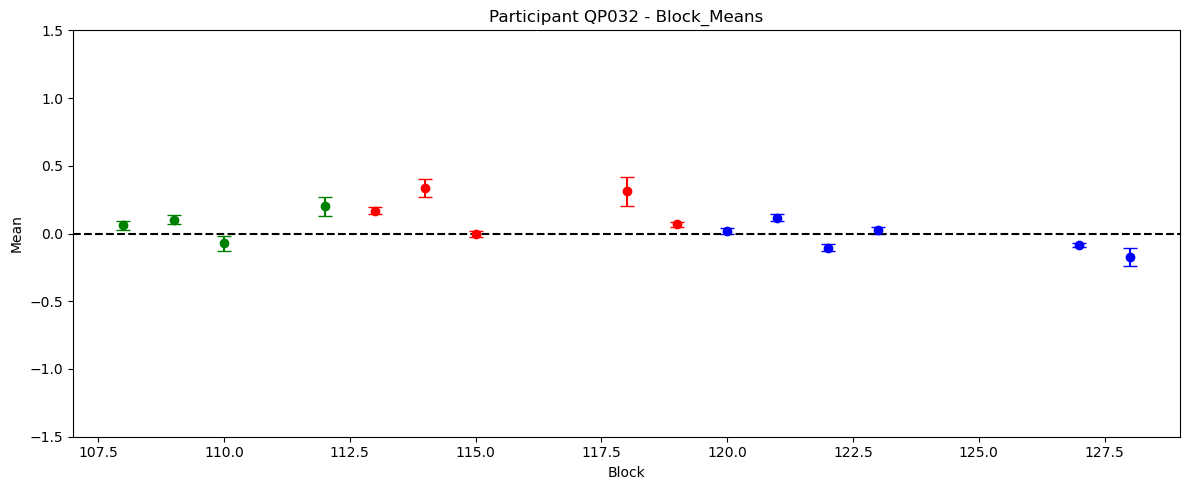

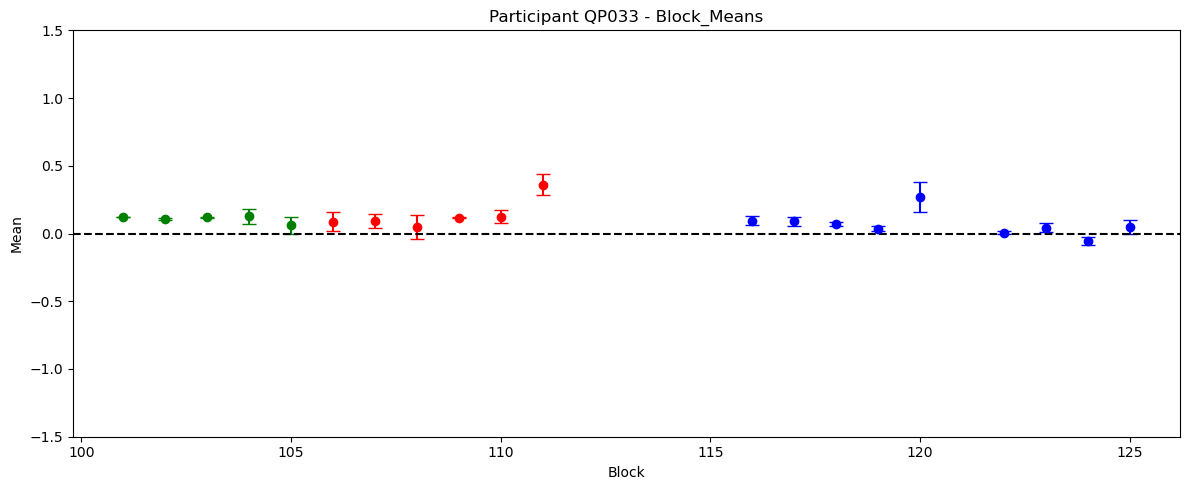

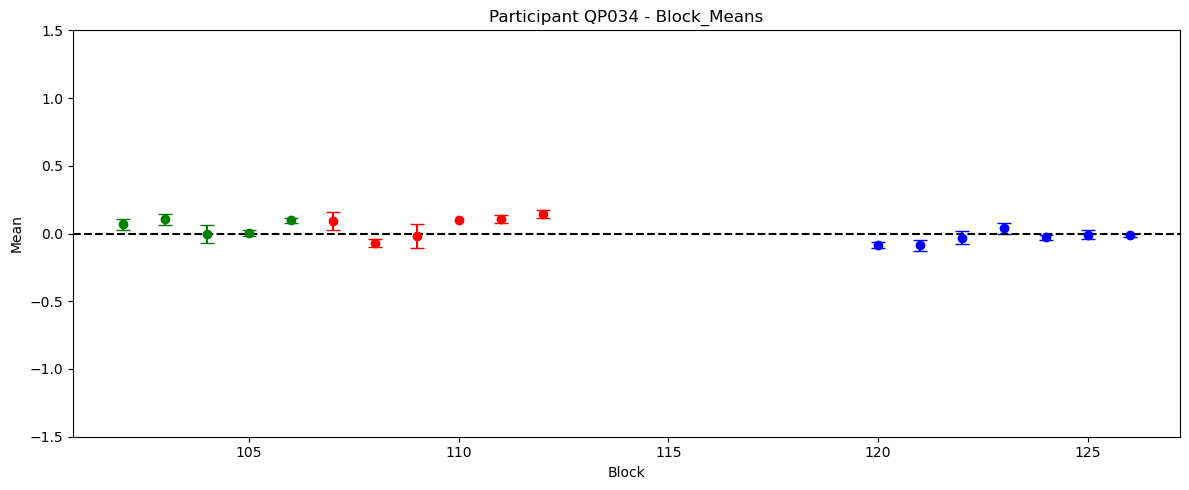

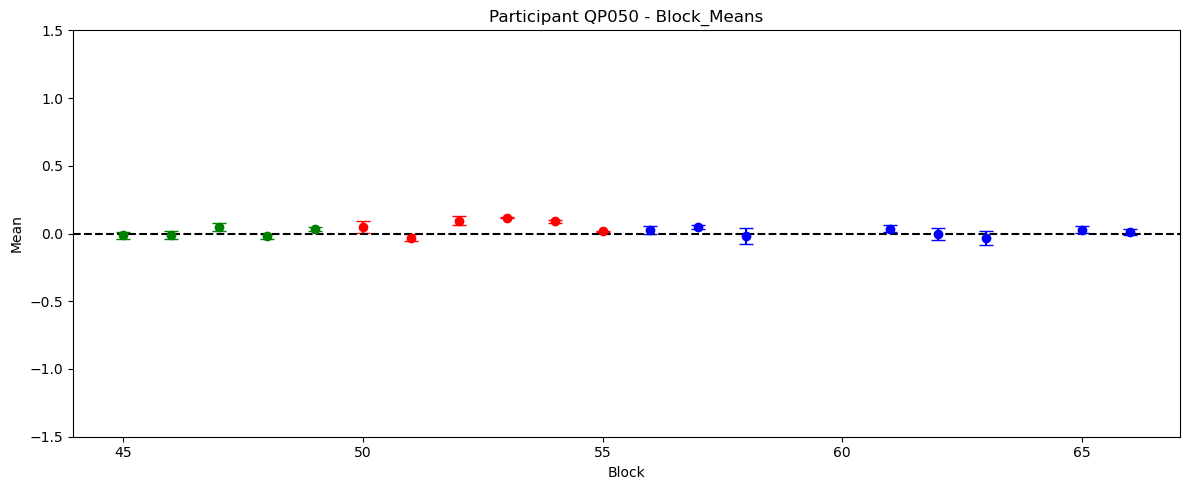

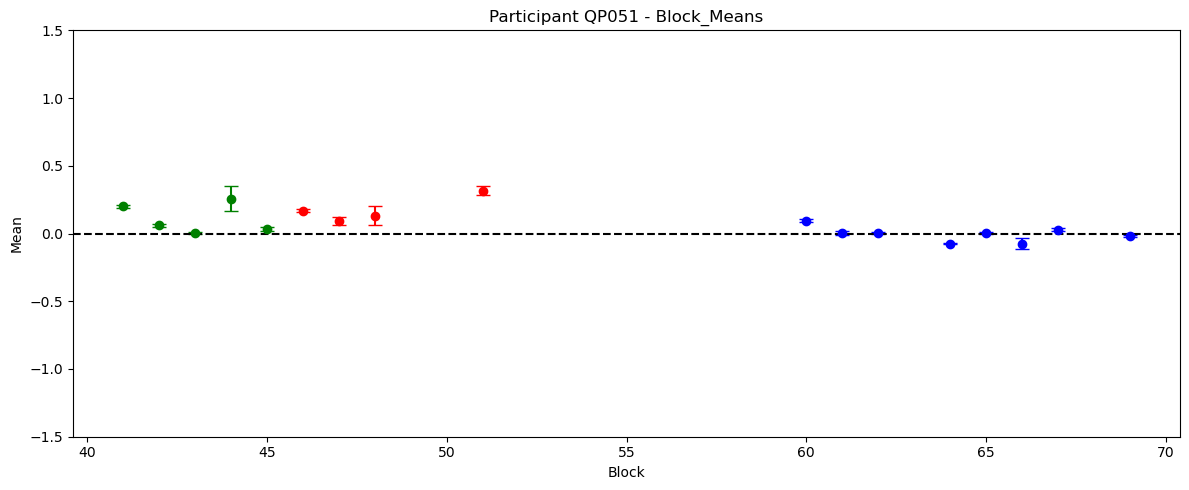

In [ ]:
color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}

marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}
error_threshold = 2 # for some reason, some points have enormous errors


metrics = ['Block_Means'
# , 'Block_Slopes', 'Block_Lapses_1', 'Block_Lapses_2'
                ]       
metric_std_devs = ['Block_Means_Std'
# , 'Block_Slopes_Std', 'Block_Lapses_1_Std', 'Block_Lapses_2_Std'
        ]
y_label_dict = {
    'Block_Means': 'Mean',
    # 'Block_Slopes': 'Sigma',
    # 'Block_Lapses_1': 'Lapse 1',
    # 'Block_Lapses_2': 'Lapse 2'
}


for participant in PARTICIPANTS:
    fig, axs = plt.subplots(1, 1, figsize=(12, 5))  # Create a 4-row subplot for each metric
    # pid_df = psych_params_df[psych_params_df['Participant_ID'] == participant]
    pid_df = filtered_psych_params_df[filtered_psych_params_df['Participant_ID'] == participant]
    
    # Only keep last n blocks
    # pid_df = pid_df[pid_df['block'] > pid_df['block'].max() - 30]

    for metric_idx, metric in enumerate(metrics):
        # ax = axs[metric_idx]
        ax = axs
        metric_std = metric_std_devs[metric_idx]
        
        # Track opto conditions encountered for legend
        opto_conditions_encountered = set()
        
        for dist in pid_df['Distribution'].unique():
            dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='block').reset_index(drop=True)
            
            try:
                for index, row in dist_df.iterrows():
                    marker = marker_dict[row['Opto_Condition']]
                    color = color_dict[dist]
                    if row[metric_std] <= error_threshold:
                        opto_conditions_encountered.add(row['Opto_Condition'])
                        ax.errorbar(x=row['block'], y=row[metric], yerr=row[metric_std],
                                    fmt=marker, ecolor=color, capsize=5, label=dist if marker == 'o' else "_nolegend_",
                                    color=color)
                    else:
                        ax.plot(row['block'], row[metric], marker, color=color, label=dist if marker == 'o' else "_nolegend_")
                    
                    # Plotting for specific conditions, adjust as necessary
                    if row['Opto_Condition'] in ['ACC', 'PPC']:
                        offset = 0.3 if row['Opto_Condition'] == 'ACC' else -0.3
                        ax.plot(row['block'], row[metric] + offset, marker_dict[row['Opto_Condition']],
                                color='k', markersize=8, alpha=0.7)

            except Exception as e:
                print(f'Participant {participant}, metric {metric} failed to plot: {e}')
        # ax.axvline(x=131, color='k', linestyle='--')
        # ax.axvline(x=111, color='k', linestyle='--')
        # ax.axvline(x=120, color='k', linestyle='--')
        # ax.axvline(x=36, color='k', linestyle='--')
        # ax.axvline(x=43, color='k', linestyle='--')

        ax.set_title(f'Participant {participant} - {metric}')
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_ylim(-1.5, 1.5)
        ax.set_xlabel('Block')
        ax.set_ylabel(y_label_dict[metric])
        # Define legends outside of the loop
        distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
        opto_condition_markers = [Line2D([0], [0], marker=marker_dict[condition], color='w', label=condition, markerfacecolor='black', markersize=10) 
                                for condition in opto_conditions_encountered]

    plt.tight_layout()
    plt.show()

In [ ]:
filter_dict = {
    'QP032': (100, 129),
    'QP033': (90, 125),
    'QP034': (90, 126),
    # 'QP049': (np.nan, np.nan),
    'QP050': (40, 67),
    'QP051': (40, 70)
}

filtered_psych_params_df = pd.DataFrame()

for participant in filter_dict.keys():
    start, end = filter_dict[participant]
    if pd.isna(start) and pd.isna(end):
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[psych_params_df['Participant_ID'] == participant]])
    else:
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[(psych_params_df['Participant_ID'] == participant) & (psych_params_df['block'] >= start) & (psych_params_df['block'] <= end)]])
        

# for QP032 remove all non Asym_Left blocks after 121
filtered_psych_params_df = filtered_psych_params_df[~((filtered_psych_params_df['Participant_ID'] == 'QP032') & 
                                                      (filtered_psych_params_df['block'] > 121) & 
                                                      (filtered_psych_params_df['Distribution'] != 'Asym_Left'))]
# for QP033, remove blocks 112 to 115
filtered_psych_params_df = filtered_psych_params_df[~((filtered_psych_params_df['Participant_ID'] == 'QP033') & 
                                                      (filtered_psych_params_df['block'] >= 112) & 
                                                      (filtered_psych_params_df['block'] <= 115))]


# for QP034, remove blocks 114 to 119
filtered_psych_params_df = filtered_psych_params_df[~((filtered_psych_params_df['Participant_ID'] == 'QP034') & 
                                                      (filtered_psych_params_df['block'] >= 114) & 
                                                      (filtered_psych_params_df['block'] <= 119))]
# for QP051, remove blocks 52-59
filtered_psych_params_df = filtered_psych_params_df[~((filtered_psych_params_df['Participant_ID'] == 'QP051') & 
                                                      (filtered_psych_params_df['block'] >= 52) & 
                                                      (filtered_psych_params_df['block'] <= 59))]

In [ ]:
sub_df = sub_df.merge(filtered_psych_params_df, on=['Participant_ID', 'block'], suffixes=('', '_y'))
sub_df = sub_df[[col for col in sub_df.columns if not col.endswith('_y')]]

# remove No_response == True
valid_df = sub_df[sub_df['No_response'] == False]

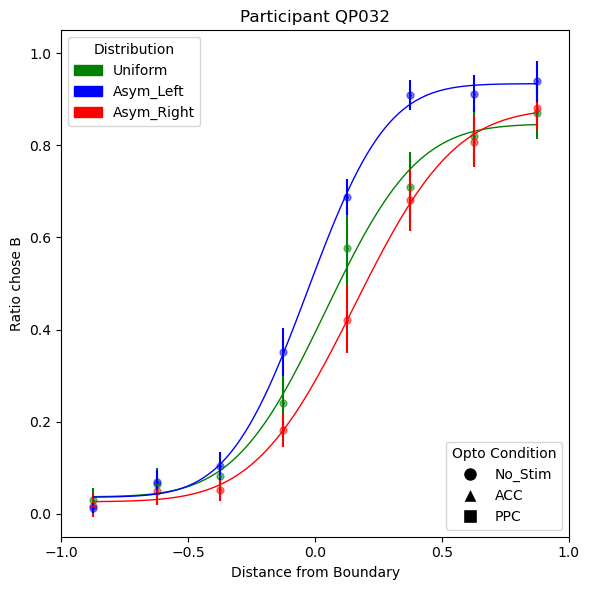

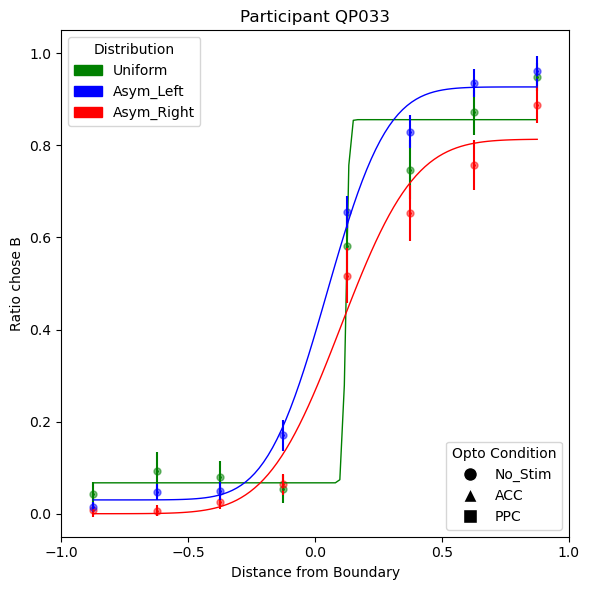

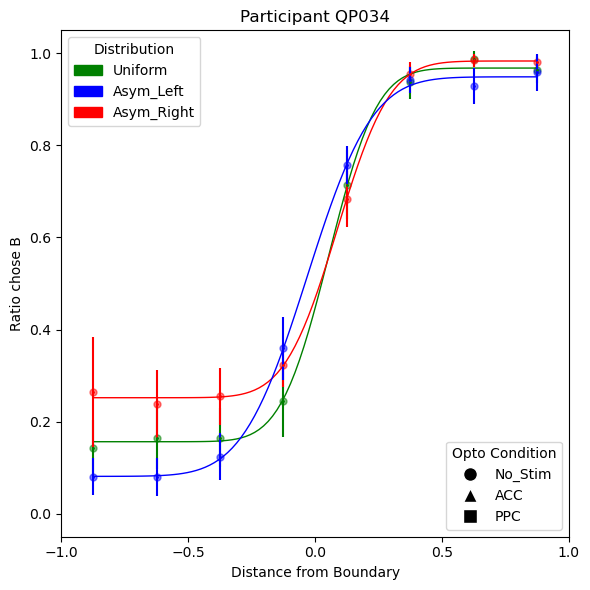

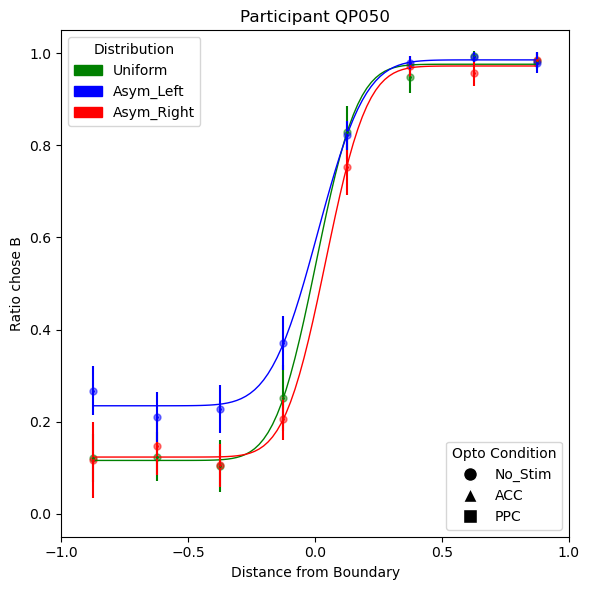

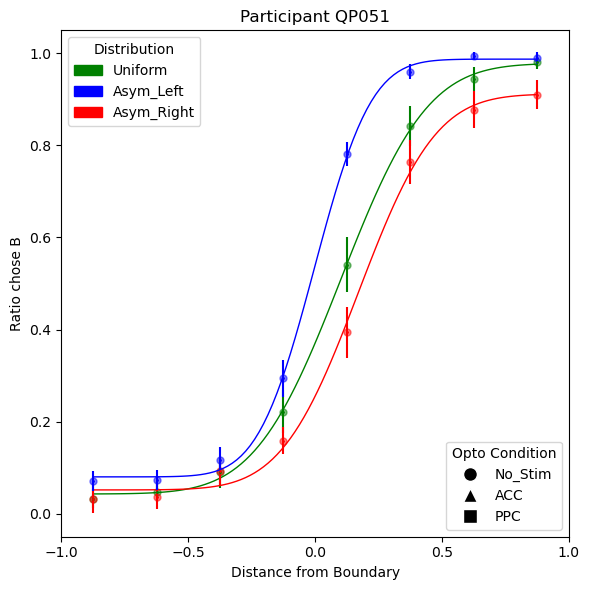

In [ ]:
opto_conditions = ['No_Stim', 'ACC', 'PPC']
participants = valid_df['Participant_ID'].unique()

# Assuming these are your predefined color and marker dictionaries
distribution_colors = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}  # Example color map
marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

for participant in participants:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    distributions = valid_df['Distribution'].unique()
    
    for opto_condition, marker in marker_dict.items():
        for distribution in distributions:
            df_filtered = valid_df[(valid_df['Participant_ID'] == participant) & (valid_df['Opto_Condition'] == opto_condition) & (valid_df['Distribution'] == distribution)]
            if not df_filtered.empty:
                popt, _ = ut.psycho_fit(df_filtered)  # Fit the psychometric curve
                color = distribution_colors[distribution]  # Color based on distribution
                
                psycho_plot(df_filtered, popt, label=f"{opto_condition} {distribution}", color=color, 
                            marker=marker, ax=ax, scatter=True, legend=False)  # Temporarily disable legend

    ax.set_title(f'Participant {participant}')

    # Create custom legend for Distributions
    distribution_patches = [Patch(color=color, label=distribution) for distribution, color in distribution_colors.items()]
    legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='upper left')

    # Create custom legend for Opto Conditions
    opto_condition_markers = [Line2D([0], [0], marker=marker, color='w', label=condition, markerfacecolor='black', markersize=10) 
                              for condition, marker in marker_dict.items() if marker]  # Exclude No_Stim if no marker needed
    legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right')

    plt.gca().add_artist(legend1)  # Add the first legend back in after adding the second
    plt.tight_layout()  # Adjust layout to make room for legends
    # save the figure in the figures folder
    # plt.savefig(FIGS_PATH + participant + '_psychometric_by_opto_condition_and_distribution.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
2000*500


1000000

### Mega mouse

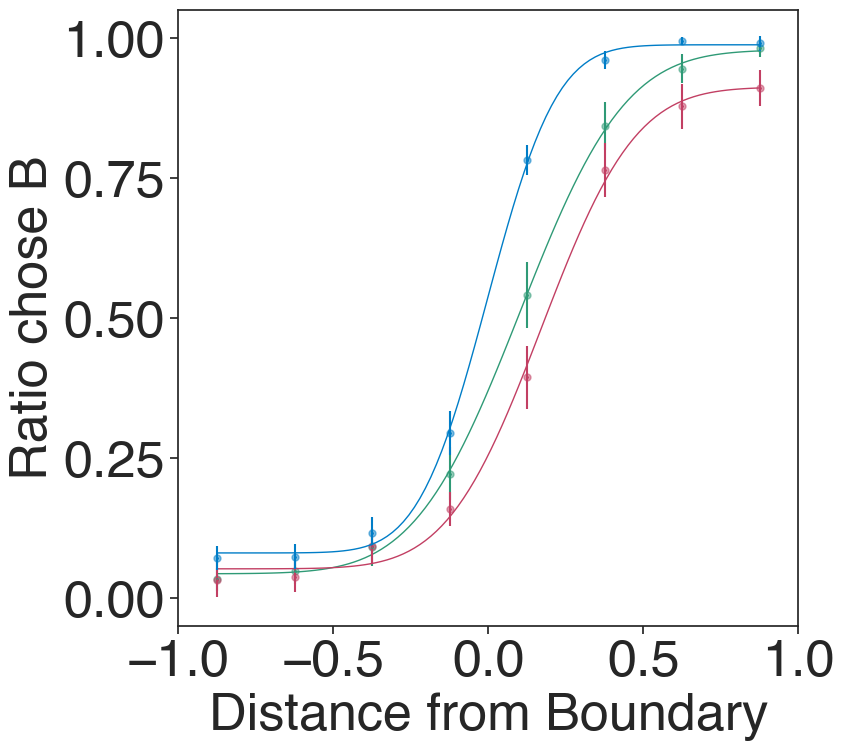

In [ ]:
opto_conditions = ['No_Stim', 'ACC', 'PPC']

# Assuming these are your predefined color and marker dictionaries
distribution_colors ={'Uniform': '#2F9A76', 'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}
marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
distributions = valid_df['Distribution'].unique()

for opto_condition, marker in marker_dict.items():
    for distribution in distributions:
        df_filtered = valid_df[(valid_df['Participant_ID'] == participant) & (valid_df['Opto_Condition'] == opto_condition) & (valid_df['Distribution'] == distribution)]
        if not df_filtered.empty:
            popt, _ = ut.psycho_fit(df_filtered)  # Fit the psychometric curve
            color = distribution_colors[distribution]  # Color based on distribution
            
            psycho_plot(df_filtered, popt, label=f"{opto_condition} {distribution}", color=color, 
                        marker=marker, ax=ax, scatter=True, legend=False)  # Temporarily disable legend

# ax.set_title('Mega Mouse')

# # Create custom legend for Distributions
# distribution_patches = [Patch(color=color, label=distribution) for distribution, color in distribution_colors.items()]
# legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='upper left')

# # Create custom legend for Opto Conditions
# opto_condition_markers = [Line2D([0], [0], marker=marker, color='w', label=condition, markerfacecolor='black', markersize=10) 
#                             for condition, marker in marker_dict.items() if marker]  # Exclude No_Stim if no marker needed
# legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right')

# plt.gca().add_artist(legend1)  # Add the first legend back in after adding the second
# #  Adjust layout to make room for legends
# # save the figure in the figures folder
plt.savefig(figs_path + 'psychometric_mega_mouse.pdf', dpi=300, bbox_inches='tight')

plt.show()

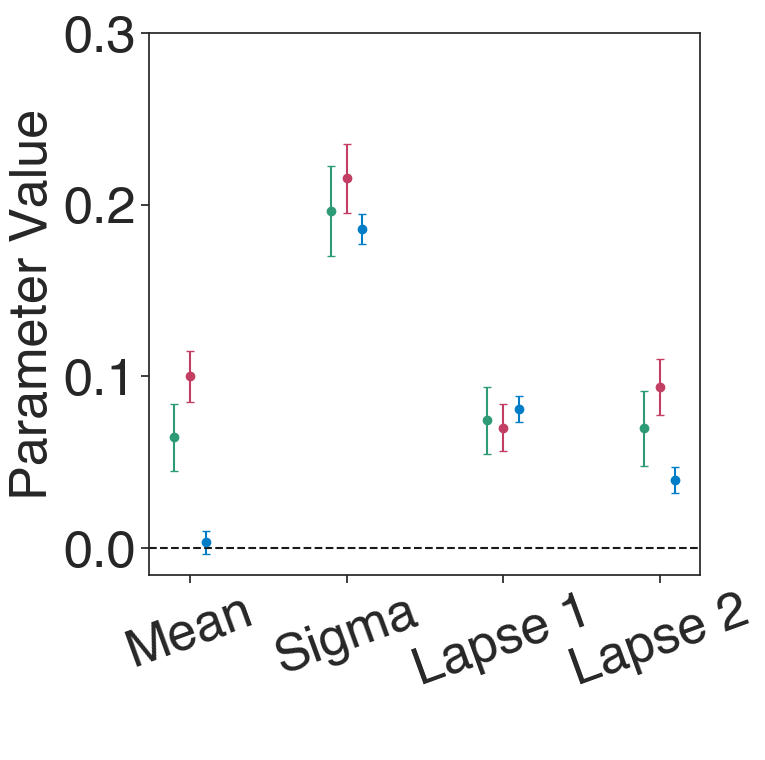

In [ ]:
plot_psycho_params(
                    df = valid_df, 
                    participant_ids = ['QP032', 'QP033', 'QP034', 'QP050', 'QP051'],
                    manual_legend = False,
                    legend=False,
                    title = ' ',
                    save_path = figs_path + 'Psychometric_Params_Cohort_1.pdf')

In [ ]:
valid_df.Distribution.unique()

array(['Uniform', 'Asym_Right', 'Asym_Left'], dtype=object)

### Means of means

In [ ]:
choice_by_pid = valid_df.groupby(['Participant_ID', 'stim_relative_binned', 'Distribution'])['choice'].mean().reset_index()
mean_of_means_df = choice_by_pid.groupby(['stim_relative_binned', 'Distribution'])['choice'].agg(['mean', 'sem']).reset_index()

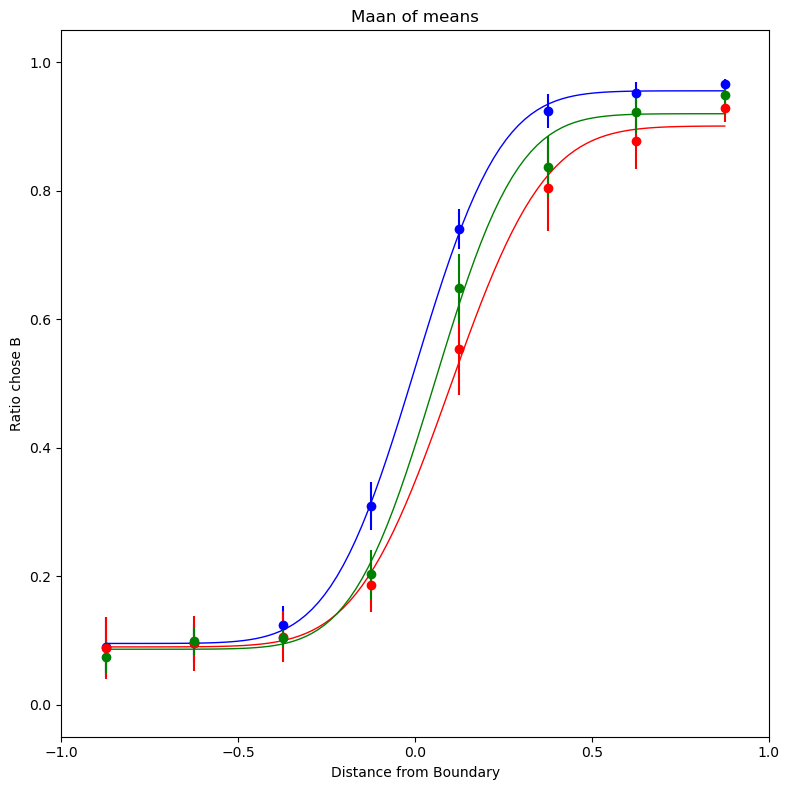

In [ ]:
distribution_colors = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}  # Example color map


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for distribution in mean_of_means_df['Distribution'].unique():
    dist_df = mean_of_means_df[mean_of_means_df['Distribution'] == distribution]
    color = distribution_colors[distribution]
    ax.errorbar(dist_df['stim_relative_binned'], dist_df['mean'], yerr=dist_df['sem'], fmt='o', color=color, label=distribution)
    popt, _ = ut.psycho_fit(dist_df, x = 'stim_relative_binned', y = 'mean')
    x = np.linspace(-1, 1, 100)
    psycho_plot(dist_df, popt, label=distribution, color=color, marker = 'o', x = 'stim_relative_binned', y = 'mean', 
                 ax=ax, scatter=False, legend=False)  # Temporarily disable legend
    # add title
    ax.set_title('Maan of means')

plt.tight_layout() 
plt.show()

## Second Cohort

In [ ]:
sub_df = pre_processed_df
# only keep data where the Stage is 'Full_Task_Disc' or 'Full_Task_Cont'
sub_df = sub_df[sub_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])]
# only keep data where the Distribution is 'Uniform' or 'Asym_Right' or 'Asym_Left'
sub_df = sub_df[sub_df['Distribution'].isin(['Uniform', 'Asym_Right', 'Asym_Left'])]
# only keep data where the Anti_Bias is False
sub_df = sub_df[sub_df['Anti_Bias'] == False]
PARTICIPANTS = ['QP062', 'QP063', 'QP070', 'QP071', 'QP079',  
                # 'QP081', 'QP082'
                ]
sub_df = sub_df[sub_df['Participant_ID'].isin(PARTICIPANTS)].reset_index(drop=True)

In [ ]:
MIN_TRIALS = 100
MIN_PERF = 0.7
BIAS_RANGE = [0.2, 0.8]

trial_counts = sub_df[sub_df['No_response'] == False].groupby(['Participant_ID', 'block'])['Trial'].count().reset_index(name='trial_count')

valid_groups = trial_counts[trial_counts['trial_count'] >= MIN_TRIALS]

sub_df = pd.merge(sub_df, valid_groups[['Participant_ID', 'block']], on=['Participant_ID', 'block'], how='inner')

proportions = sub_df[sub_df['No_response'] == False].groupby(['Participant_ID', 'block'])['correct'].mean().reset_index(name='correct_proportion')

valid_proportions = proportions[proportions['correct_proportion'] > MIN_PERF]

sub_df = pd.merge(sub_df, valid_proportions[['Participant_ID', 'block']], on=['Participant_ID', 'block'], how='inner')

biases = sub_df[sub_df['No_response'] == False].groupby(['Participant_ID', 'block'])['choice'].mean().reset_index(name='bias')

valid_biases = biases[(biases['bias'] > BIAS_RANGE[0]) & (biases['bias'] < BIAS_RANGE[1])]

sub_df = pd.merge(sub_df, valid_biases[['Participant_ID', 'block']], on=['Participant_ID', 'block'], how='inner')

In [ ]:
# add an Opto_Condition column which will be No_Stim for all rows
sub_df['Opto_Condition'] = 'No_Stim'
# add an Opto_On column which will be False for all rows
sub_df['Opto_On'] = False

In [ ]:
psych_params_df = ut.gen_blockwise_psych_params(sub_df, PARTICIPANTS)
psych_params_df = psych_params_df.rename(columns={'Block': 'block'})

composite_keys = ['Participant_ID', 'block']  
# Dropping duplicate rows in data_df based on composite keys
data_df_unique = sub_df.drop_duplicates(subset=composite_keys)
# Columns from data_df to merge
columns_to_merge = ['Opto_Condition']
# Merging
psych_params_df = psych_params_df.merge(data_df_unique[composite_keys + columns_to_merge], 
                                        on=composite_keys, how='left')

In [ ]:
filter_dict = {
    'QP062': (0, 999),
    'QP063': (0, 999),
    'QP070': (0, 999),
    'QP071': (0, 999),
    'QP079': (0, 999),
    # 'QP081': (0, 999),
    # 'QP082': (0, 999)
}

filtered_psych_params_df = pd.DataFrame()

for participant in filter_dict.keys():
    start, end = filter_dict[participant]
    if pd.isna(start) and pd.isna(end):
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[psych_params_df['Participant_ID'] == participant]])
    else:
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[(psych_params_df['Participant_ID'] == participant) & (psych_params_df['block'] >= start) & (psych_params_df['block'] <= end)]])

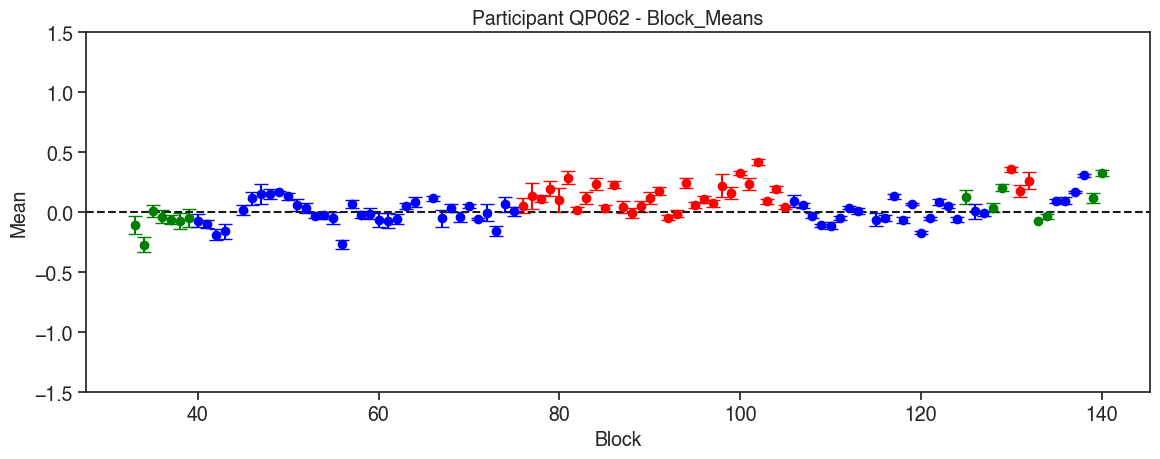

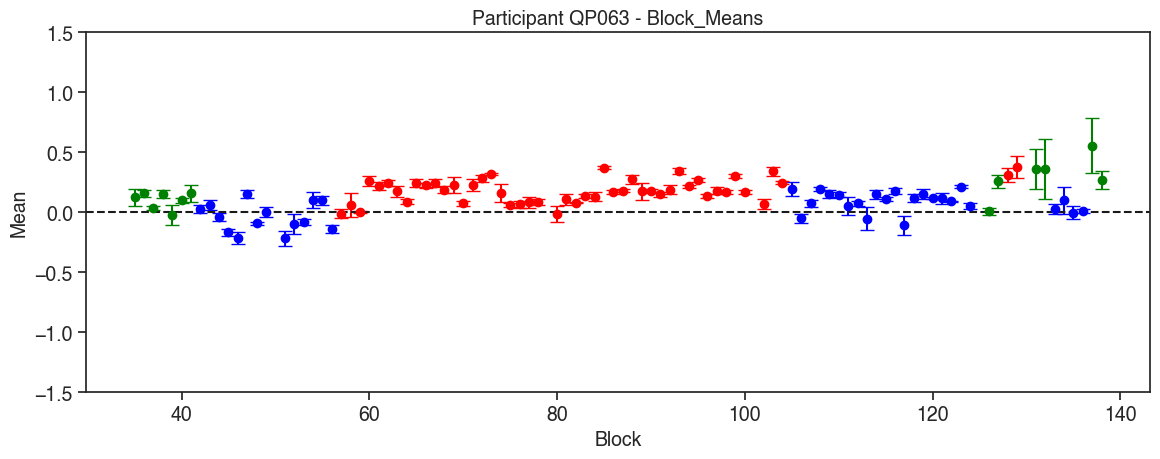

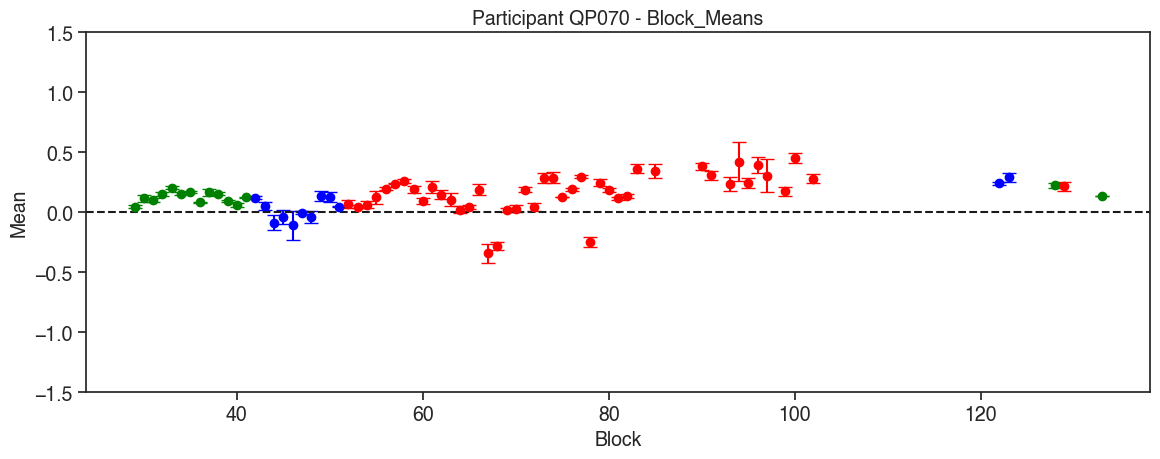

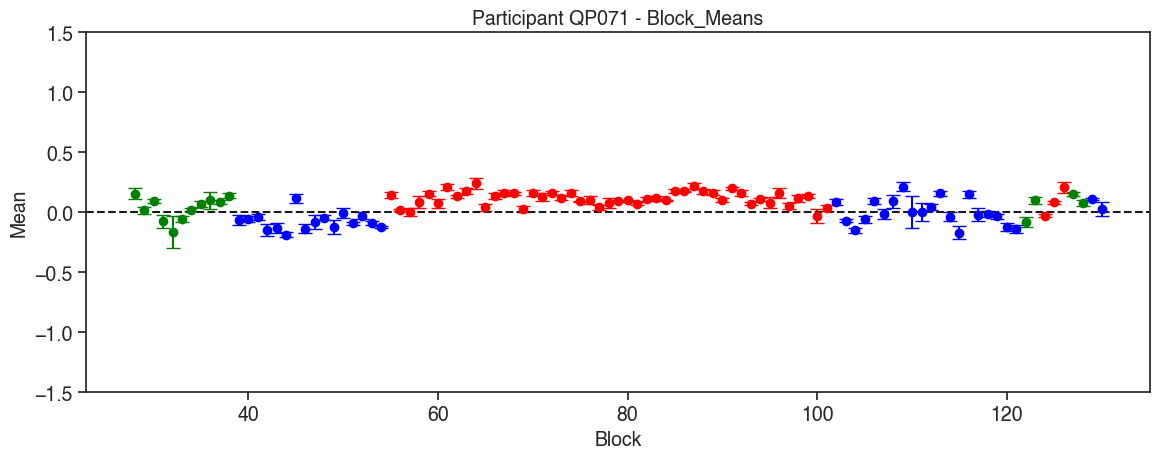

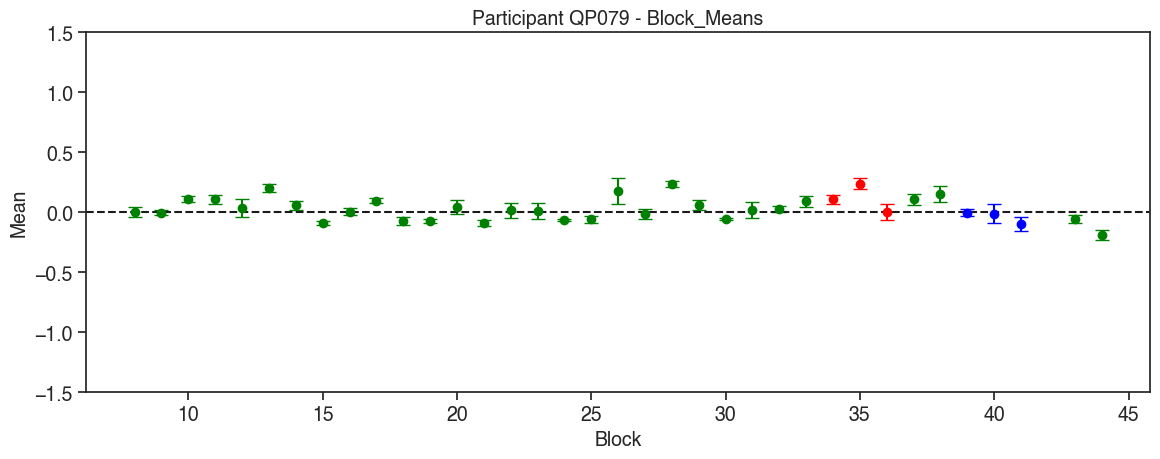

In [ ]:
color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}

marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}
error_threshold = 2 # for some reason, some points have enormous errors


metrics = ['Block_Means'
# , 'Block_Slopes', 'Block_Lapses_1', 'Block_Lapses_2'
                ]       
metric_std_devs = ['Block_Means_Std'
# , 'Block_Slopes_Std', 'Block_Lapses_1_Std', 'Block_Lapses_2_Std'
        ]
y_label_dict = {
    'Block_Means': 'Mean',
    # 'Block_Slopes': 'Sigma',
    # 'Block_Lapses_1': 'Lapse 1',
    # 'Block_Lapses_2': 'Lapse 2'
}


for participant in PARTICIPANTS:
    fig, axs = plt.subplots(1, 1, figsize=(12, 5))  # Create a 4-row subplot for each metric
    # pid_df = psych_params_df[psych_params_df['Participant_ID'] == participant]
    pid_df = filtered_psych_params_df[filtered_psych_params_df['Participant_ID'] == participant]
    
    # Only keep last n blocks
    # pid_df = pid_df[pid_df['block'] > pid_df['block'].max() - 30]

    for metric_idx, metric in enumerate(metrics):
        # ax = axs[metric_idx]
        ax = axs
        metric_std = metric_std_devs[metric_idx]
        
        # Track opto conditions encountered for legend
        opto_conditions_encountered = set()
        
        for dist in pid_df['Distribution'].unique():
            dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='block').reset_index(drop=True)
            
            try:
                for index, row in dist_df.iterrows():
                    marker = marker_dict[row['Opto_Condition']]
                    color = color_dict[dist]
                    if row[metric_std] <= error_threshold:
                        opto_conditions_encountered.add(row['Opto_Condition'])
                        ax.errorbar(x=row['block'], y=row[metric], yerr=row[metric_std],
                                    fmt=marker, ecolor=color, capsize=5, label=dist if marker == 'o' else "_nolegend_",
                                    color=color)
                    else:
                        ax.plot(row['block'], row[metric], marker, color=color, label=dist if marker == 'o' else "_nolegend_")
                    
                    # Plotting for specific conditions, adjust as necessary
                    if row['Opto_Condition'] in ['ACC', 'PPC']:
                        offset = 0.3 if row['Opto_Condition'] == 'ACC' else -0.3
                        ax.plot(row['block'], row[metric] + offset, marker_dict[row['Opto_Condition']],
                                color='k', markersize=8, alpha=0.7)

            except Exception as e:
                print(f'Participant {participant}, metric {metric} failed to plot: {e}')
        # ax.axvline(x=45, color='k', linestyle='--')
        # ax.axvline(x=10, color='k', linestyle='--')
        # ax.axvline(x=82, color='k', linestyle='--')
        # ax.axvline(x=36, color='k', linestyle='--')
        # ax.axvline(x=43, color='k', linestyle='--')

        ax.set_title(f'Participant {participant} - {metric}')
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_ylim(-1.5, 1.5)
        ax.set_xlabel('Block')
        ax.set_ylabel(y_label_dict[metric])
        # Define legends outside of the loop
        distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
        opto_condition_markers = [Line2D([0], [0], marker=marker_dict[condition], color='w', label=condition, markerfacecolor='black', markersize=10) 
                                for condition in opto_conditions_encountered]

    plt.tight_layout()
    plt.show()

In [ ]:
filter_dict = {
    'QP062': (35, 104),
    'QP063': (0, 74),
    'QP070': (0, 110),
    'QP071': (0, 105),
    'QP079': (0, 44),
}

filtered_psych_params_df = pd.DataFrame()

for participant in filter_dict.keys():
    start, end = filter_dict[participant]
    if pd.isna(start) and pd.isna(end):
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[psych_params_df['Participant_ID'] == participant]])
    else:
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[(psych_params_df['Participant_ID'] == participant) & 
                                                                                        (psych_params_df['block'] >= start) & (psych_params_df['block'] <= end)]])

# for QP032 remove all non Asym_Left blocks after 121
ANIMAL_ID = 'QP062'
START = 45
END = 94
filtered_psych_params_df = filtered_psych_params_df[~((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
                                                      (filtered_psych_params_df['block'] >= START) &
                                                      (filtered_psych_params_df['block'] <= END))]
# for QP063, remove blocks 47, 49, 54, 55, and 57 to 59
ANIMAL_ID = 'QP063'
BLOCKS_TO_REMOVE = [42, 43, 47, 49, 54, 55, 57, 58, 59]
filtered_psych_params_df = filtered_psych_params_df[~((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
                                                      (filtered_psych_params_df['block'].isin(BLOCKS_TO_REMOVE)))]

# for QP070, remove blocks 42, 43, and 49 to 82, but keep 44 to 48
ANIMAL_ID = 'QP070'
BLOCKS_TO_REMOVE_RANGES = [(42, 43), (49, 82)]
mask = pd.Series(False, index=filtered_psych_params_df.index)
for start, end in BLOCKS_TO_REMOVE_RANGES:
    mask |= ((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
             (filtered_psych_params_df['block'] >= start) &
             (filtered_psych_params_df['block'] <= end))
filtered_psych_params_df = filtered_psych_params_df[~mask]

ANIMAL_ID = 'QP071'
BLOCKS_TO_REMOVE_RANGES = [(45, 45), (100, 110)]
mask = pd.Series(False, index=filtered_psych_params_df.index)
for start, end in BLOCKS_TO_REMOVE_RANGES:
    mask |= ((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
             (filtered_psych_params_df['block'] >= start) &
             (filtered_psych_params_df['block'] <= end))
filtered_psych_params_df = filtered_psych_params_df[~mask]

ANIMAL_ID = 'QP079'
BLOCKS_TO_REMOVE_RANGES = [(10, 30), (33, 33), (37, 38), (43, 45)]
mask = pd.Series(False, index=filtered_psych_params_df.index)
for start, end in BLOCKS_TO_REMOVE_RANGES:
    mask |= ((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
             (filtered_psych_params_df['block'] >= start) &
             (filtered_psych_params_df['block'] <= end))
filtered_psych_params_df = filtered_psych_params_df[~mask]

In [ ]:
sub_df = sub_df.merge(filtered_psych_params_df, on=['Participant_ID', 'block'], suffixes=('', '_y'))
sub_df = sub_df[[col for col in sub_df.columns if not col.endswith('_y')]]

# remove No_response == True
valid_df = sub_df[sub_df['No_response'] == False]

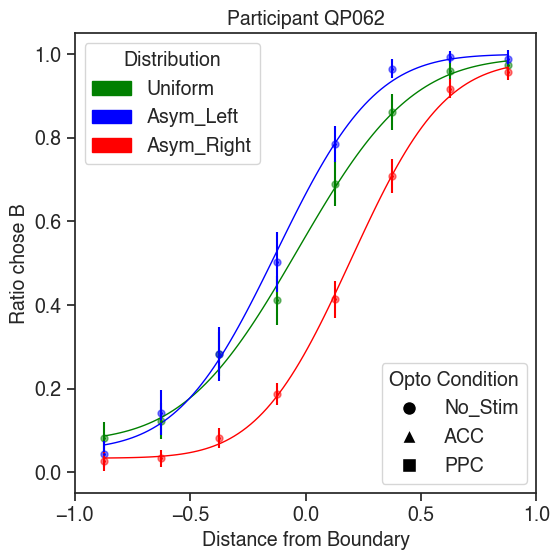

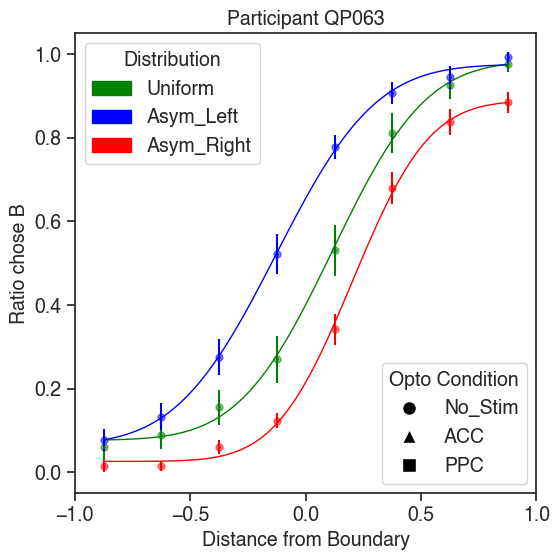

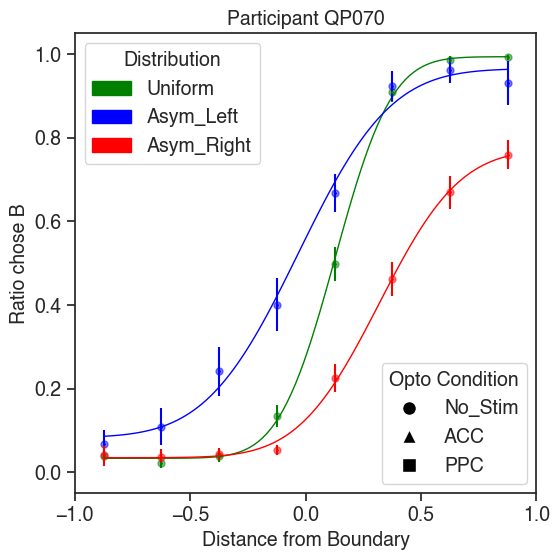

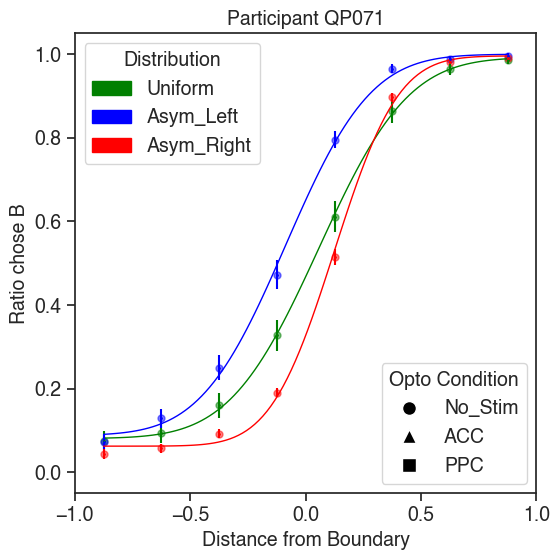

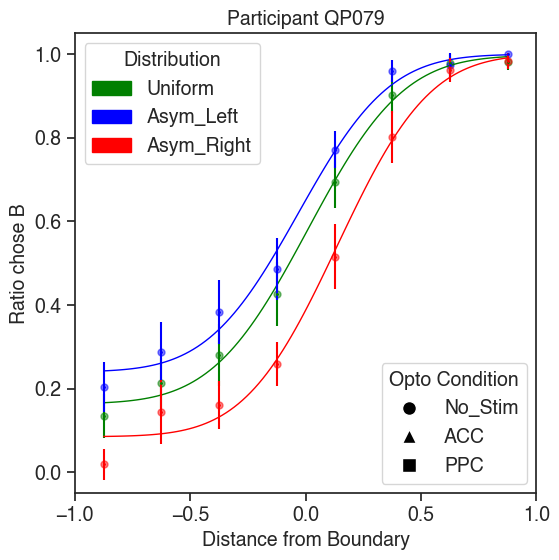

In [ ]:
opto_conditions = ['No_Stim', 'ACC', 'PPC']
participants = valid_df['Participant_ID'].unique()

# Assuming these are your predefined color and marker dictionaries
distribution_colors = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}  # Example color map
marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

for participant in participants:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    distributions = valid_df['Distribution'].unique()
    
    for opto_condition, marker in marker_dict.items():
        for distribution in distributions:
            df_filtered = valid_df[(valid_df['Participant_ID'] == participant) & (valid_df['Opto_Condition'] == opto_condition) & (valid_df['Distribution'] == distribution)]
            if not df_filtered.empty:
                popt, _ = ut.psycho_fit(df_filtered)  # Fit the psychometric curve
                color = distribution_colors[distribution]  # Color based on distribution
                
                psycho_plot(df_filtered, popt, label=f"{opto_condition} {distribution}", color=color, 
                            marker=marker, ax=ax, scatter=True, legend=False)  # Temporarily disable legend

    ax.set_title(f'Participant {participant}')

    # Create custom legend for Distributions
    distribution_patches = [Patch(color=color, label=distribution) for distribution, color in distribution_colors.items()]
    legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='upper left')

    # Create custom legend for Opto Conditions
    opto_condition_markers = [Line2D([0], [0], marker=marker, color='w', label=condition, markerfacecolor='black', markersize=10) 
                              for condition, marker in marker_dict.items() if marker]  # Exclude No_Stim if no marker needed
    legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right')

    plt.gca().add_artist(legend1)  # Add the first legend back in after adding the second
    plt.tight_layout()  # Adjust layout to make room for legends
    # save the figure in the figures folder
    # plt.savefig(FIGS_PATH + participant + '_psychometric_by_opto_condition_and_distribution.pdf', dpi=300, bbox_inches='tight')

plt.show()

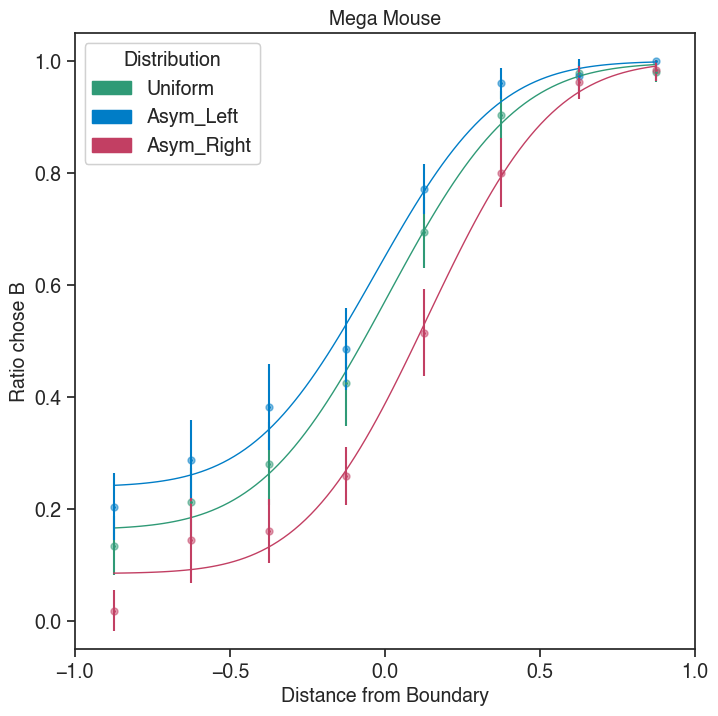

In [ ]:
opto_conditions = ['No_Stim', 'ACC', 'PPC']

# Assuming these are your predefined color and marker dictionaries
distribution_colors ={'Uniform': '#2F9A76', 'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}
marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
distributions = valid_df['Distribution'].unique()

for opto_condition, marker in marker_dict.items():
    for distribution in distributions:
        df_filtered = valid_df[(valid_df['Participant_ID'] == participant) & (valid_df['Opto_Condition'] == opto_condition) & (valid_df['Distribution'] == distribution)]
        if not df_filtered.empty:
            popt, _ = ut.psycho_fit(df_filtered)  # Fit the psychometric curve
            color = distribution_colors[distribution]  # Color based on distribution
            
            psycho_plot(df_filtered, popt, label=f"{opto_condition} {distribution}", color=color, 
                        marker=marker, ax=ax, scatter=True, legend=False)  # Temporarily disable legend

ax.set_title('Mega Mouse')

# Create custom legend for Distributions
distribution_patches = [Patch(color=color, label=distribution) for distribution, color in distribution_colors.items()]
legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='upper left')

# # Create custom legend for Opto Conditions
# opto_condition_markers = [Line2D([0], [0], marker=marker, color='w', label=condition, markerfacecolor='black', markersize=10) 
#                             for condition, marker in marker_dict.items() if marker]  # Exclude No_Stim if no marker needed
# legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right')

plt.gca().add_artist(legend1)  # Add the first legend back in after adding the second
#  Adjust layout to make room for legends
# save the figure in the figures folder
# plt.savefig(figs_path + 'psychometric_mega_mouse.pdf', dpi=300, bbox_inches='tight')

plt.show()

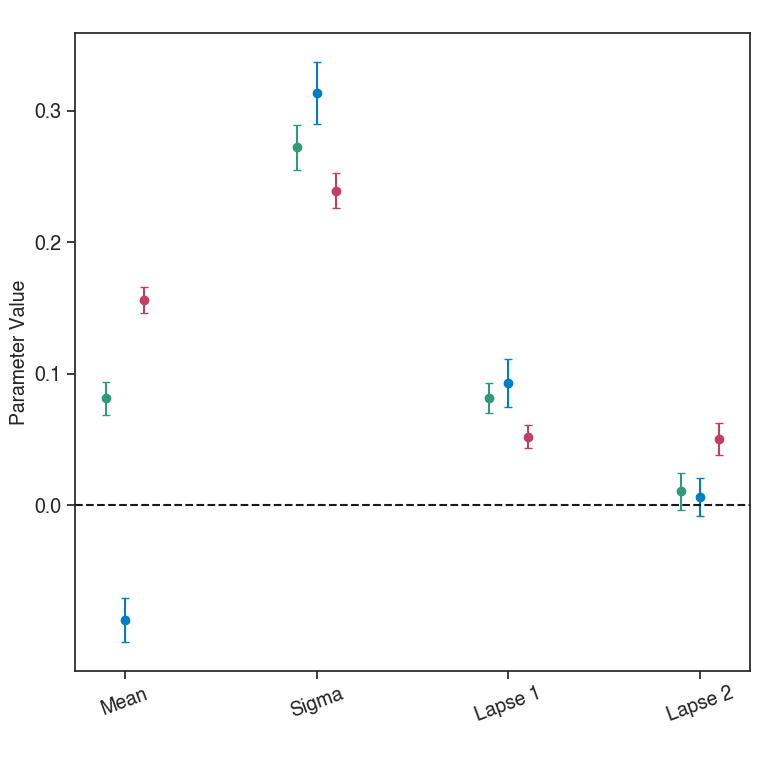

In [ ]:
plot_psycho_params(
                    df = valid_df, 
                    participant_ids = ['QP062', 'QP063', 'QP070', 'QP071', 'QP079'],
                    manual_legend = False,
                    legend=False,
                    title = ' ',
                    save_path = None)

### Mean of means

In [ ]:
choice_by_pid = valid_df.groupby(['Participant_ID', 'stim_relative_binned', 'Distribution'])['choice'].mean().reset_index()
mean_of_means_df = choice_by_pid.groupby(['stim_relative_binned', 'Distribution'])['choice'].agg(['mean', 'sem']).reset_index()

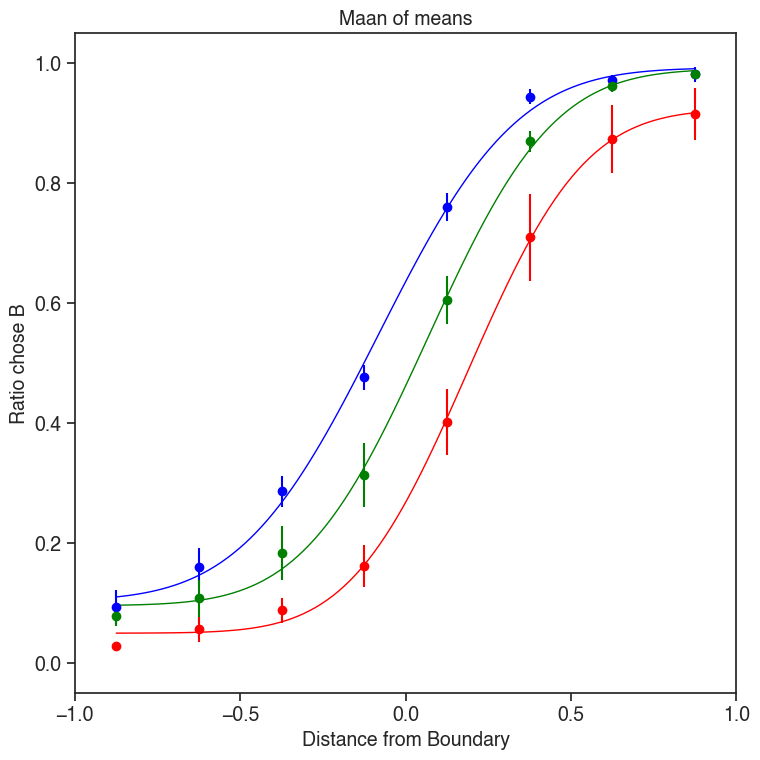

In [ ]:
distribution_colors = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}  # Example color map

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for distribution in mean_of_means_df['Distribution'].unique():
    dist_df = mean_of_means_df[mean_of_means_df['Distribution'] == distribution]
    color = distribution_colors[distribution]
    ax.errorbar(dist_df['stim_relative_binned'], dist_df['mean'], yerr=dist_df['sem'], fmt='o', color=color, label=distribution)
    popt, _ = ut.psycho_fit(dist_df, x = 'stim_relative_binned', y = 'mean')
    x = np.linspace(-1, 1, 100)
    psycho_plot(dist_df, popt, label=distribution, color=color, marker = 'o', x = 'stim_relative_binned', y = 'mean', 
                 ax=ax, scatter=False, legend=False)  # Temporarily disable legend
    ax.set_title('Maan of means')

plt.tight_layout() 
plt.show()

# Figure 3

In [ ]:
sub_df = pre_processed_df
sub_df = sub_df[sub_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])]
sub_df = sub_df[sub_df['Distribution'].isin(['Uniform', 'Asym_Right', 'Asym_Left'])]
sub_df = sub_df[sub_df['Anti_Bias'] == False]
PARTICIPANTS = ['QP032', 'QP033', 'QP034', 'QP050', 'QP051',
                'QP062', 'QP063', 
                # 'QP070',
                  'QP071', 
                  # 'QP079',
                ]  
sub_df = sub_df[sub_df['Participant_ID'].isin(PARTICIPANTS)].reset_index(drop=True)

In [ ]:
MIN_TRIALS = 100
MIN_PERF = 0.7
BIAS_RANGE = [0.2, 0.8]

trial_counts = sub_df[sub_df['No_response'] == False].groupby(['Participant_ID', 'block'])['Trial'].count().reset_index(name='trial_count')
valid_groups = trial_counts[trial_counts['trial_count'] >= MIN_TRIALS]
sub_df = pd.merge(sub_df, valid_groups[['Participant_ID', 'block']], on=['Participant_ID', 'block'], how='inner')
proportions = sub_df[sub_df['No_response'] == False].groupby(['Participant_ID', 'block'])['correct'].mean().reset_index(name='correct_proportion')
valid_proportions = proportions[proportions['correct_proportion'] > MIN_PERF]
sub_df = pd.merge(sub_df, valid_proportions[['Participant_ID', 'block']], on=['Participant_ID', 'block'], how='inner')
biases = sub_df[sub_df['No_response'] == False].groupby(['Participant_ID', 'block'])['choice'].mean().reset_index(name='bias')
valid_biases = biases[(biases['bias'] > BIAS_RANGE[0]) & (biases['bias'] < BIAS_RANGE[1])]
sub_df = pd.merge(sub_df, valid_biases[['Participant_ID', 'block']], on=['Participant_ID', 'block'], how='inner')

In [ ]:
# add an Opto_Condition column which will be No_Stim for all rows
sub_df['Opto_Condition'] = 'No_Stim'
# add an Opto_On column which will be False for all rows
sub_df['Opto_On'] = False

In [ ]:
psych_params_df = ut.gen_blockwise_psych_params(sub_df, PARTICIPANTS)
psych_params_df = psych_params_df.rename(columns={'Block': 'block'})
composite_keys = ['Participant_ID', 'block']  
data_df_unique = sub_df.drop_duplicates(subset=composite_keys)
columns_to_merge = ['Opto_Condition']
psych_params_df = psych_params_df.merge(data_df_unique[composite_keys + columns_to_merge], 
                                        on=composite_keys, how='left')

In [ ]:
filter_dict = {
    'QP032': (0, 999),
    'QP033': (00, 999),
    'QP034': (95, 999),
    'QP050': (0, 999),
    'QP051': (0, 999),
    'QP062': (0, 999),
    'QP063': (0, 999),
    'QP070': (0, 999),
    'QP071': (0, 999),
    'QP079': (0, 999),
}

filtered_psych_params_df = pd.DataFrame()

for participant in filter_dict.keys():
    start, end = filter_dict[participant]
    if pd.isna(start) and pd.isna(end):
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[psych_params_df['Participant_ID'] == participant]])
    else:
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[(psych_params_df['Participant_ID'] == participant) & 
                                                                                        (psych_params_df['block'] >= start) & (psych_params_df['block'] <= end)]])

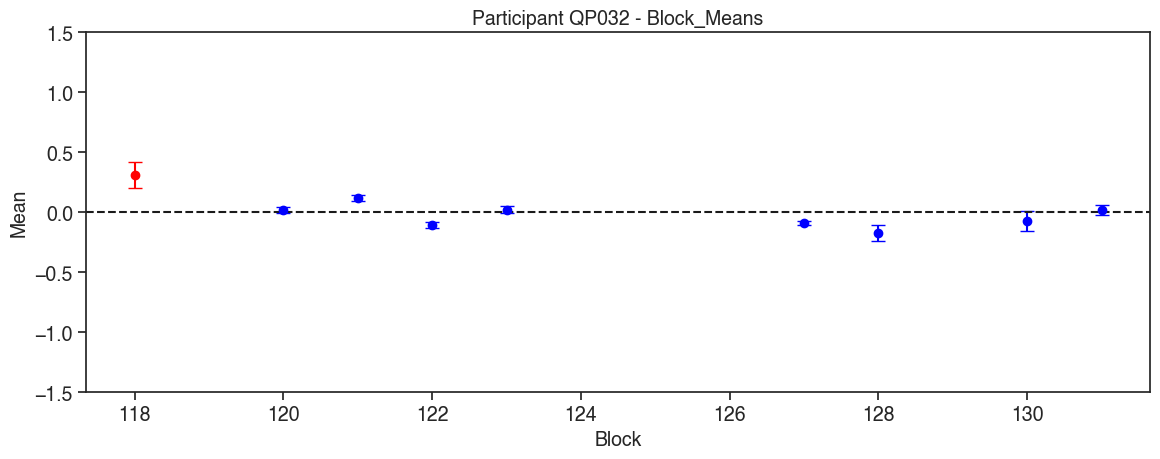

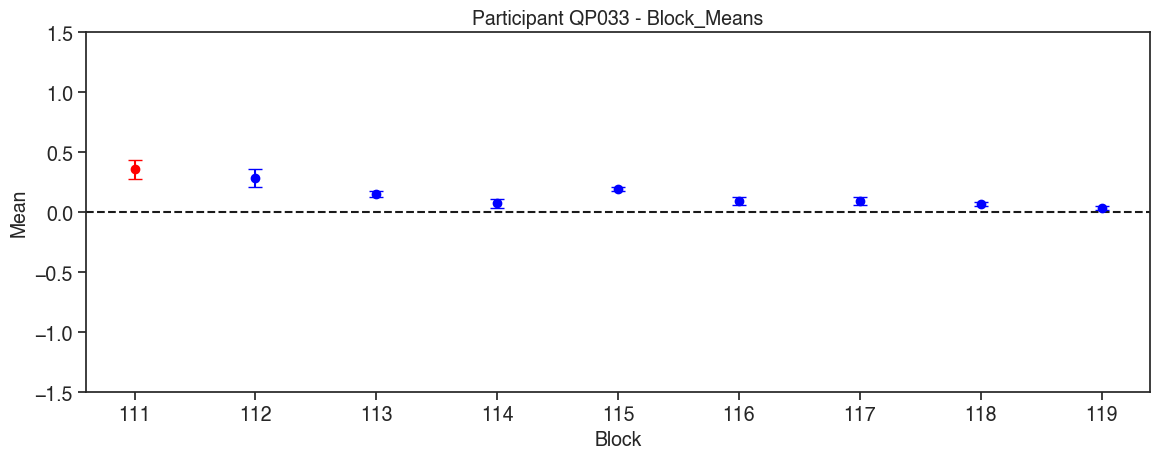

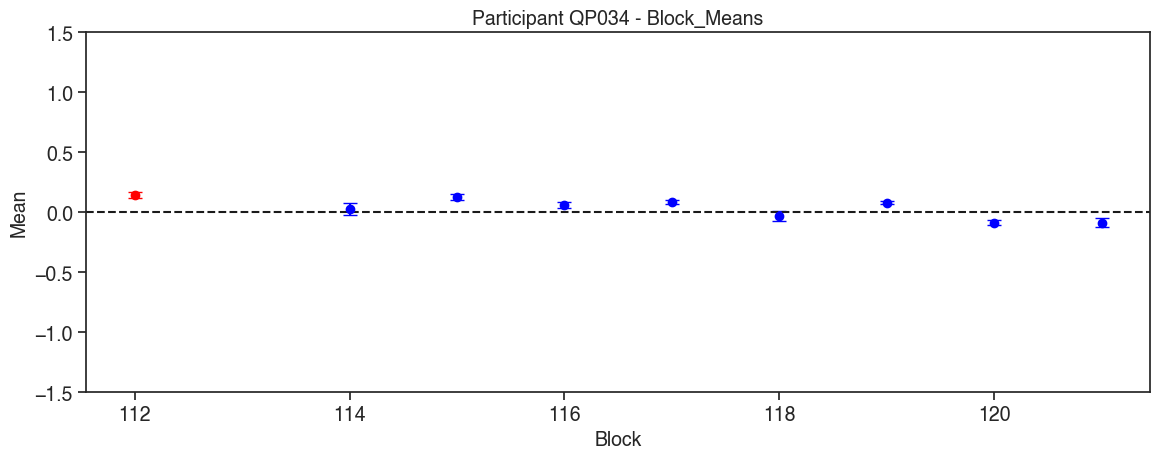

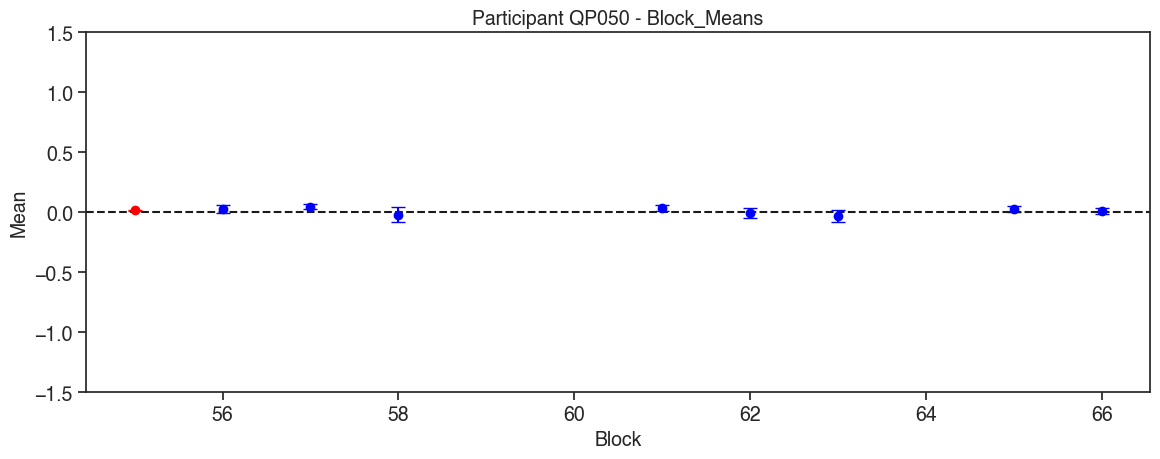

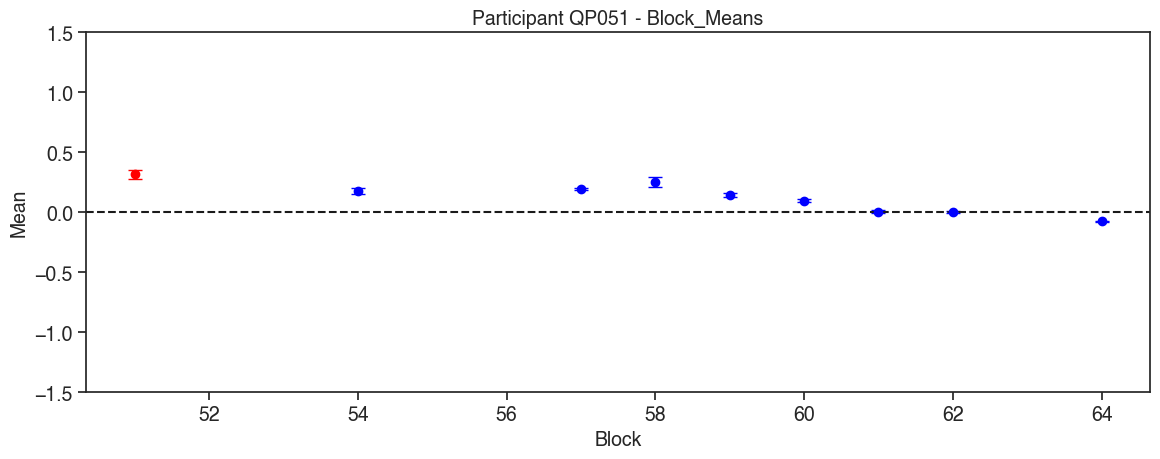

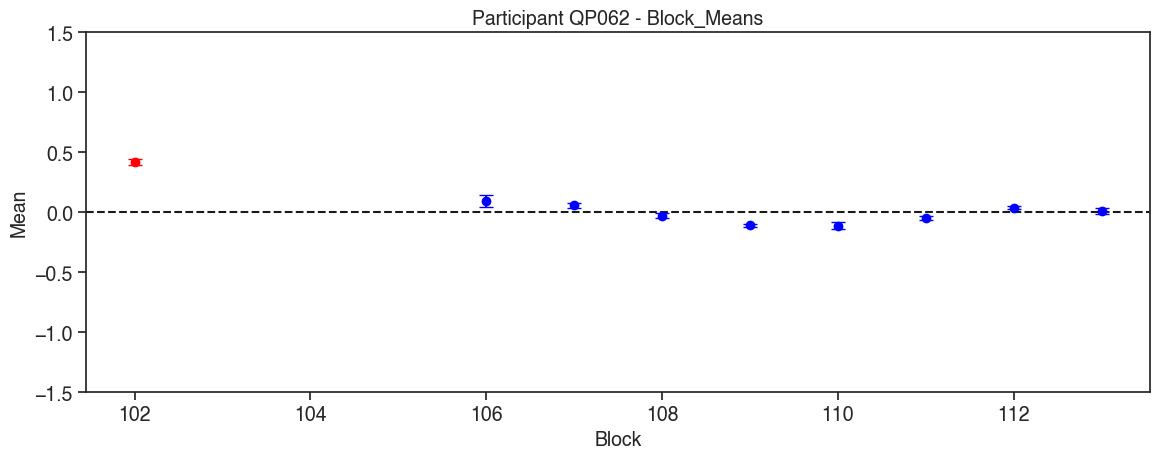

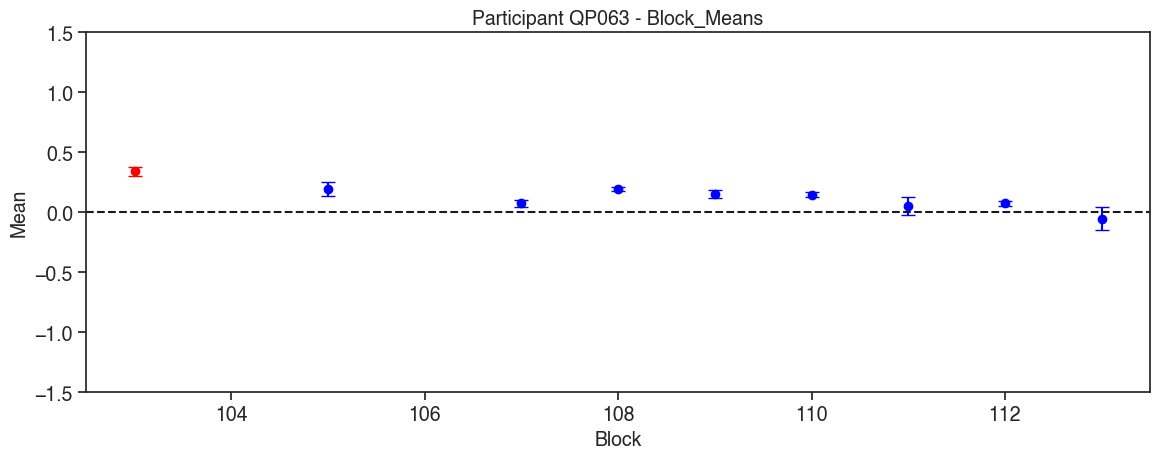

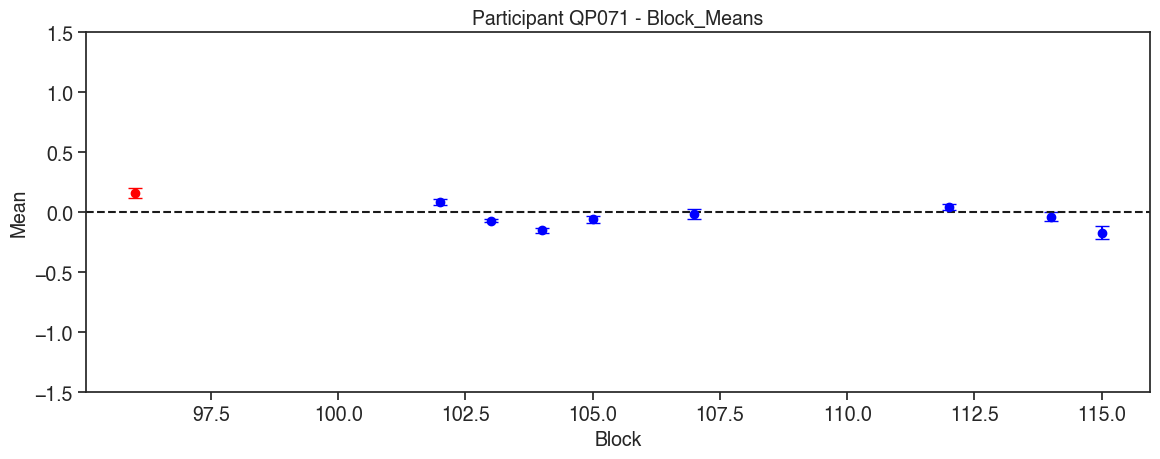

In [ ]:
color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}
marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}
error_threshold = 2 # for some reason, some points have enormous errors
metrics = ['Block_Means'
# , 'Block_Slopes', 'Block_Lapses_1', 'Block_Lapses_2'
                ]       
metric_std_devs = ['Block_Means_Std'
# , 'Block_Slopes_Std', 'Block_Lapses_1_Std', 'Block_Lapses_2_Std'
        ]
y_label_dict = {
    'Block_Means': 'Mean',
    # 'Block_Slopes': 'Sigma',
    # 'Block_Lapses_1': 'Lapse 1',
    # 'Block_Lapses_2': 'Lapse 2'
}


for participant in PARTICIPANTS:
    fig, axs = plt.subplots(1, 1, figsize=(12, 5))  # Create a 4-row subplot for each metric
    pid_df = filtered_psych_params_df[filtered_psych_params_df['Participant_ID'] == participant]
    # Only keep last n blocks
    # pid_df = pid_df[pid_df['block'] > pid_df['block'].max() - 30]

    for metric_idx, metric in enumerate(metrics):
        # ax = axs[metric_idx]
        ax = axs
        metric_std = metric_std_devs[metric_idx]
        
        # Track opto conditions encountered for legend
        opto_conditions_encountered = set()
        
        for dist in pid_df['Distribution'].unique():
            dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='block').reset_index(drop=True)
            
            try:
                for index, row in dist_df.iterrows():
                    marker = marker_dict[row['Opto_Condition']]
                    color = color_dict[dist]
                    if row[metric_std] <= error_threshold:
                        opto_conditions_encountered.add(row['Opto_Condition'])
                        ax.errorbar(x=row['block'], y=row[metric], yerr=row[metric_std],
                                    fmt=marker, ecolor=color, capsize=5, label=dist if marker == 'o' else "_nolegend_",
                                    color=color)
                    else:
                        ax.plot(row['block'], row[metric], marker, color=color, label=dist if marker == 'o' else "_nolegend_")
                    if row['Opto_Condition'] in ['ACC', 'PPC']:
                        offset = 0.3 if row['Opto_Condition'] == 'ACC' else -0.3
                        ax.plot(row['block'], row[metric] + offset, marker_dict[row['Opto_Condition']],
                                color='k', markersize=8, alpha=0.7)
            except Exception as e:
                print(f'Participant {participant}, metric {metric} failed to plot: {e}')
        # ax.axvline(x=131, color='k', linestyle='--')
        ax.set_title(f'Participant {participant} - {metric}')
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_ylim(-1.5, 1.5)
        ax.set_xlabel('Block')
        ax.set_ylabel(y_label_dict[metric])
        distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
        opto_condition_markers = [Line2D([0], [0], marker=marker_dict[condition], color='w', label=condition, markerfacecolor='black', markersize=10) 
                                for condition in opto_conditions_encountered]

    plt.tight_layout()
    plt.show()

In [ ]:
filter_dict = {
    'QP032': (117, 132),
    'QP033': (111, 119),
    'QP034': (112, 121),
    'QP050': (55, 66),
    'QP051': (51, 64),
    'QP062': (102, 114),
    'QP063': (103, 113),
    # 'QP070': (50, 130),
    'QP071': (96, 115),
    # 'QP079': (25, 45),
}

filtered_psych_params_df = pd.DataFrame()

for participant in filter_dict.keys():
    start, end = filter_dict[participant]
    if pd.isna(start) and pd.isna(end):
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[psych_params_df['Participant_ID'] == participant]])
    else:
        filtered_psych_params_df = pd.concat([filtered_psych_params_df, psych_params_df[(psych_params_df['Participant_ID'] == participant) & 
                                                                                        (psych_params_df['block'] >= start) & (psych_params_df['block'] <= end)]])
        
ANIMAL_ID = 'QP032'
BLOCKS_TO_REMOVE_RANGES = [(119, 119), (125, 126)]
mask = pd.Series(False, index=filtered_psych_params_df.index)
for start, end in BLOCKS_TO_REMOVE_RANGES:
    mask |= ((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
             (filtered_psych_params_df['block'] >= start) &
             (filtered_psych_params_df['block'] <= end))
filtered_psych_params_df = filtered_psych_params_df[~mask]

ANIMAL_ID = 'QP051'
BLOCKS_TO_REMOVE_RANGES = [(52, 53)]
mask = pd.Series(False, index=filtered_psych_params_df.index)
for start, end in BLOCKS_TO_REMOVE_RANGES:
    mask |= ((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
             (filtered_psych_params_df['block'] >= start) &
             (filtered_psych_params_df['block'] <= end))
filtered_psych_params_df = filtered_psych_params_df[~mask]

ANIMAL_ID = 'QP062'
BLOCKS_TO_REMOVE_RANGES = [(103, 105)]
mask = pd.Series(False, index=filtered_psych_params_df.index)
for start, end in BLOCKS_TO_REMOVE_RANGES:
    mask |= ((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
             (filtered_psych_params_df['block'] >= start) &
             (filtered_psych_params_df['block'] <= end))
filtered_psych_params_df = filtered_psych_params_df[~mask]

ANIMAL_ID = 'QP063'
BLOCKS_TO_REMOVE_RANGES = [(104, 104), (106, 106)]
mask = pd.Series(False, index=filtered_psych_params_df.index)
for start, end in BLOCKS_TO_REMOVE_RANGES:
    mask |= ((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
             (filtered_psych_params_df['block'] >= start) &
             (filtered_psych_params_df['block'] <= end))
filtered_psych_params_df = filtered_psych_params_df[~mask]

ANIMAL_ID = 'QP071'
BLOCKS_TO_REMOVE_RANGES = [(97, 101), (106, 106), (108, 111), (113, 113)]
mask = pd.Series(False, index=filtered_psych_params_df.index)
for start, end in BLOCKS_TO_REMOVE_RANGES:
    mask |= ((filtered_psych_params_df['Participant_ID'] == ANIMAL_ID) &
             (filtered_psych_params_df['block'] >= start) &
             (filtered_psych_params_df['block'] <= end))
filtered_psych_params_df = filtered_psych_params_df[~mask]

In [ ]:
filtered_psych_params_df

,Participant_ID,block,Distribution,Block_Means,Block_Slopes,Block_Lapses_1,Block_Lapses_2,Block_Means_Std,Block_Slopes_Std,Block_Lapses_1_Std,Block_Lapses_2_Std,Opto_Condition
22,QP032,1,Asym_Right,0.310563,0.369368,0.029076,7.186220e-02,0.107655,0.134822,0.050557,0.147469,No_Stim
24,QP032,2,Asym_Left,0.016914,0.205974,0.026346,1.020853e-01,0.023400,0.030946,0.024520,0.025196,No_Stim
25,QP032,3,Asym_Left,0.117396,0.243677,0.026109,1.247802e-01,0.027017,0.036574,0.023402,0.029582,No_Stim
26,QP032,4,Asym_Left,-0.105941,0.257760,0.033805,5.244227e-02,0.026165,0.035468,0.030004,0.024008,No_Stim
27,QP032,5,Asym_Left,0.023161,0.250316,0.053622,5.339366e-03,0.026512,0.035858,0.027611,0.028925,No_Stim
...,...,...,...,...,...,...,...,...,...,...,...,...
783,QP071,5,Asym_Left,-0.058708,0.249458,0.049774,1.958326e-02,0.029524,0.039957,0.033078,0.029396,No_Stim
785,QP071,6,Asym_Left,-0.012578,0.323162,0.080630,4.314903e-23,0.040200,0.056320,0.039610,0.038286,No_Stim
790,QP071,7,Asym_Left,0.041804,0.257840,0.106891,3.404106e-13,0.025580,0.034680,0.024529,0.026752,No_Stim
792,QP071,8,Asym_Left,-0.038229,0.253227,0.143238,4.807625e-20,0.036684,0.049669,0.036869,0.034109,No_Stim


In [ ]:
# need ti merge this with the original data using the block and participant id

In [ ]:
# for every paricipant in filtered_psych_params_df, re0-index the block column
for participant in filtered_psych_params_df['Participant_ID'].unique():
    filtered_psych_params_df.loc[filtered_psych_params_df['Participant_ID'] == participant, 'block'] = range(1, len(filtered_psych_params_df[filtered_psych_params_df['Participant_ID'] == participant]) + 1)

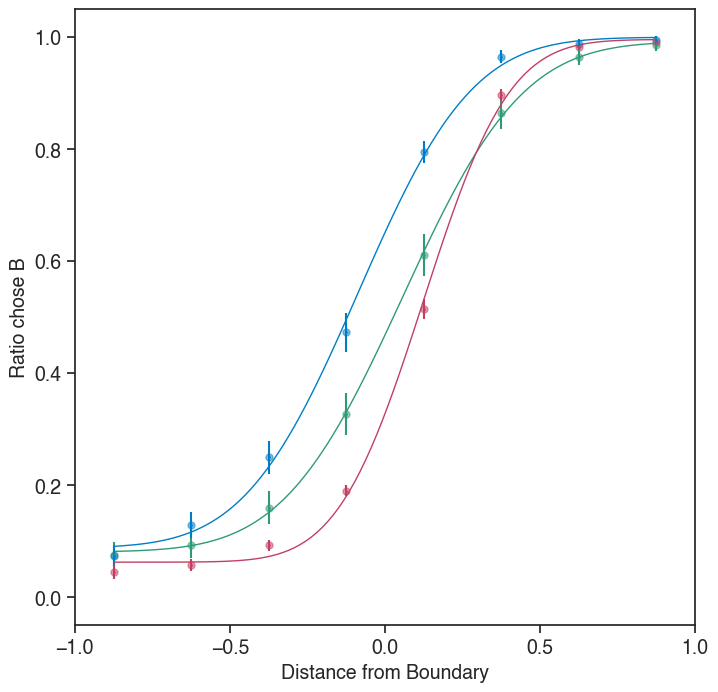

In [ ]:
opto_conditions = ['No_Stim', 'ACC', 'PPC']

# Assuming these are your predefined color and marker dictionaries
distribution_colors ={'Uniform': '#2F9A76', 'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}
marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
distributions = valid_df['Distribution'].unique()

for opto_condition, marker in marker_dict.items():
    for distribution in distributions:
        df_filtered = valid_df[(valid_df['Participant_ID'] == participant) & (valid_df['Opto_Condition'] == opto_condition) & (valid_df['Distribution'] == distribution)]
        if not df_filtered.empty:
            popt, _ = ut.psycho_fit(df_filtered)  # Fit the psychometric curve
            color = distribution_colors[distribution]  # Color based on distribution
            
            psycho_plot(df_filtered, popt, label=f"{opto_condition} {distribution}", color=color, 
                        marker=marker, ax=ax, scatter=True, legend=False)  # Temporarily disable legend

# ax.set_title('Mega Mouse')

# # Create custom legend for Distributions
# distribution_patches = [Patch(color=color, label=distribution) for distribution, color in distribution_colors.items()]
# legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='upper left')

# # Create custom legend for Opto Conditions
# opto_condition_markers = [Line2D([0], [0], marker=marker, color='w', label=condition, markerfacecolor='black', markersize=10) 
#                             for condition, marker in marker_dict.items() if marker]  # Exclude No_Stim if no marker needed
# legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right')

# plt.gca().add_artist(legend1)  # Add the first legend back in after adding the second
# #  Adjust layout to make room for legends
# # save the figure in the figures folder
# plt.savefig(figs_path + 'psychometric_mega_mouse.pdf', dpi=300, bbox_inches='tight')

plt.show()

## Filter data with GLM-HMM to check for improvements

In [ ]:
def format_data_hmmglm(df, Participant_ID, input_dim, 
                       feature = 'stim_relative_binned',
                       bias = 1,
                       target = 'choice'):
    '''
    Format data for HMM-GLM
    Args:
        df: dataframe with all the data
        Participant_ID: participant ID
        input_dim: number of input dimensions
        feature: feature to use for input
        bias: bias to add to input
        target: target to predict
    Returns:
        inpts: list of inputs
        true_choices: list of true choices
        animal_df: dataframe with data for the current participant
    '''
    animal_df = df[df['Participant_ID'] == Participant_ID]
    animal_df = animal_df[animal_df['No_response'] == False]
    stim_vals = []
    for block in animal_df['block'].unique():
        stim_vals.append(animal_df[animal_df['block'] == block][feature].to_numpy())

    true_choices = []
    for block in animal_df['block'].unique():
        block_choices = animal_df[animal_df['block'] == block][target].astype(int).values
        true_choices.append(block_choices)
    true_choices = [np.transpose([array]) for array in true_choices]

    num_sess = len(true_choices) # number of sessions
    num_trials_per_sess = [len(choice) for choice in true_choices] # number of trials per session

    inpts = [] # initialize inpts list
    for sess in range(num_sess):
        num_trials = num_trials_per_sess[sess]
        sess_inpts = np.ones((num_trials, input_dim))
        sess_inpts[:, 0] = stim_vals[sess]
        sess_inpts[:, 1] = bias
        inpts.append(sess_inpts)
    return inpts, true_choices, animal_df

In [ ]:
import numpy.random as npr
import ssm
from ssm.util import find_permutation

npr.seed(6)

In [ ]:
# Set the parameters of the GLM-HMM
num_states = 6       # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

In [ ]:
inpts, true_choices, animal_df = format_data_hmmglm(valid_df, 'QP033', input_dim = input_dim)

In [ ]:
N_iters = 1000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

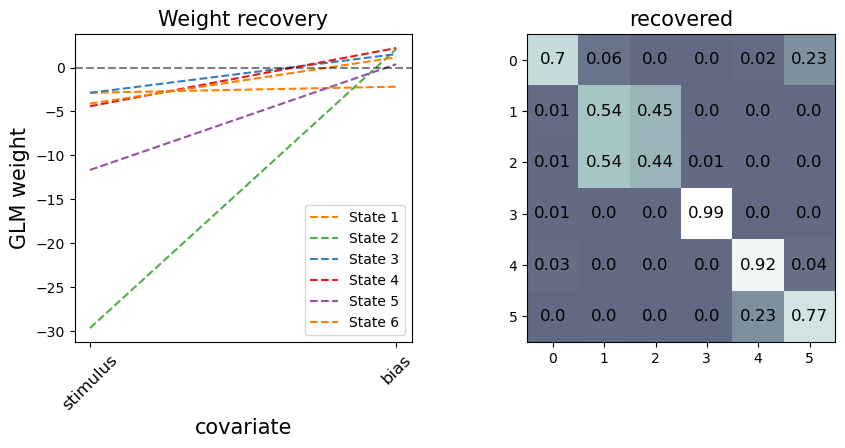

In [ ]:
color_dict = {0: '#ff7f00', 1: '#4daf4a', 2: '#377eb8', 3: '#e41a1c', 4: '#984ea3', 5: '#ff7f00', 6: '#4daf4a', 7: '#377eb8', 8: '#e41a1c'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# First plot
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    ax1.plot(range(input_dim), recovered_weights[k][0], color=color_dict[k],
             lw=1.5,  label='State ' + str(k+1), linestyle='--')
ax1.tick_params(axis='y', labelsize=10)
ax1.set_ylabel("GLM weight", fontsize=15)
ax1.set_xlabel("covariate", fontsize=15)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['stimulus', 'bias'], fontsize=12, rotation=45)
ax1.axhline(y=0, color="k", alpha=0.5, ls="--")
ax1.legend()
ax1.set_title("Weight recovery", fontsize=15)

# Second plot
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
im = ax2.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = ax2.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
ax2.set_xlim(-0.5, num_states - 0.5)
ax2.set_xticks(range(0, num_states))
# ax2.set_xticklabels(('1', '2', '3'), fontsize=10)
ax2.set_yticks(range(0, num_states))
# ax2.set_yticklabels(('1', '2', '3'), fontsize=10)
ax2.set_ylim(num_states - 0.5, -0.5)
ax2.set_title("recovered", fontsize=15)

plt.subplots_adjust(wspace=0.3)
plt.show()

In [ ]:
# Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices, inpts)]


Text(0.5, 0, 'trial #')

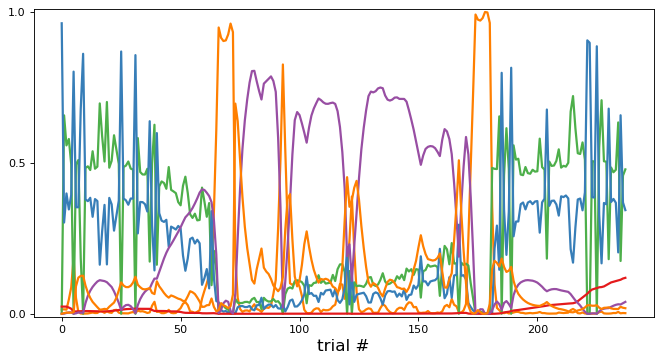

In [ ]:
fig = plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
# color_dict = {0: '#ff7f00', 1: '#4daf4a', 2: '#377eb8'}

sess_id = 1 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=color_dict[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)

In [ ]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)


Text(0, 0.5, 'frac. occupancy')

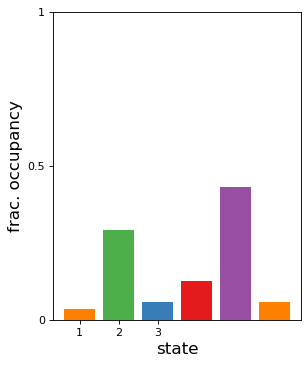

In [ ]:
fig = plt.figure(figsize=(4, 5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, 
    color = color_dict[z]
    )
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10) 
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

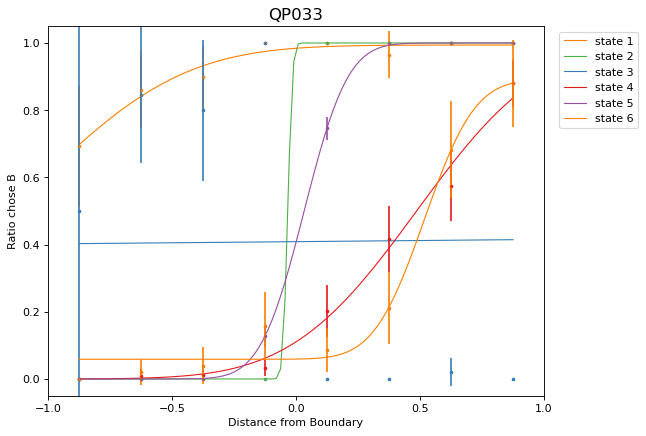

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for state in range(num_states):
    state_df = animal_df[state_max_posterior == state]
    ut.psycho_plot(state_df, ut.psycho_fit(state_df)[0], 
                   label= 'state ' + str(state+1), 
                   color=color_dict[state], 
                   ax=ax)

plt.title(animal_df.Participant_ID.unique()[0], fontsize=15)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

In [ ]:
# Break execution here
raise Exception('Stop here')

Exception: Stop here

In [ ]:
# for session in range(len(posterior_probs)):
#     ut.plot_state_probabilities(posterior_probs, session, num_states, color_dict, title='Session ' + str(animal_df.block.unique()[session]),
#                             legend_bbox = None,
#                             save_path = None)

In [ ]:
# Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Define the range of numbers of states to evaluate
n_states_range = range(1, 21)

# Initialize a KFold object to generate the train/validation indices for each fold
n_splits = 5
N_iters = 20
kf = KFold(n_splits)

# Define a dictionary to store the cross-validation results
cv_scores = {}

# Loop over the number of states to evaluate
for n_states in n_states_range:

    # Initialize a new HMM-GLM with the current number of states
    hmm_glm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
    
    # Initialize an array to store the validation log-likelihoods for the current number of states
    val_scores = np.zeros(n_splits)
    
    # Loop over the folds generated by the KFold object
    for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
        
        # Split the data into training and validation sets for the current fold
        x_train_fold = [inpts[i] for i in train_indices]
        y_train_fold = [true_choices[i] for i in train_indices]
        x_val_fold = [inpts[i] for i in val_indices]
        y_val_fold = [true_choices[i] for i in val_indices]
        
        # Fit the HMM-GLM to the training data for the current fold
        _ = hmm_glm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=10**-4)
        
        # Evaluate the log-likelihood of the validation data for the current fold
        val_scores[i_fold] = hmm_glm.log_likelihood(y_val_fold, inputs=x_val_fold)
    
    # Compute the mean validation score across all folds for the current number of states
    cv_scores[n_states] = np.mean(val_scores)

# Print the cross-validation scores for each number of states
for n_states in n_states_range:
    print(f"n_states = {n_states}, CV score = {cv_scores[n_states]}")

In [ ]:
# set a random seed
npr.seed(5)
# Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions
# Define the range of numbers of states to evaluate and other constants
n_states_range = range(1, 4)
n_splits = 5
N_iters = 200
kf = KFold(n_splits)

# Assuming inpts, true_choices, obs_dim, input_dim, and num_categories are defined elsewhere in your notebook

# Function to evaluate a single state count
def evaluate_state(n_states, inpts, true_choices, obs_dim, input_dim, num_categories):
    val_scores = np.zeros(n_splits)
    for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
        x_train_fold = [inpts[i] for i in train_indices]
        y_train_fold = [true_choices[i] for i in train_indices]
        x_val_fold = [inpts[i] for i in val_indices]
        y_val_fold = [true_choices[i] for i in val_indices]

        hmm_glm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs",
                             observation_kwargs={"C": num_categories}, transitions="standard")
        hmm_glm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=1e-4)

        val_scores[i_fold] = hmm_glm.log_likelihood(y_val_fold, inputs=x_val_fold)

    return n_states, np.mean(val_scores)

# Parallel execution using joblib
cv_scores = Parallel(n_jobs=-1)(delayed(evaluate_state)(n_states, inpts, true_choices, obs_dim, input_dim, num_categories) for n_states in n_states_range)

# Convert list of tuples to dictionary
cv_scores_dict = {n_states: score for n_states, score in cv_scores}

# Print the cross-validation scores
for n_states, score in sorted(cv_scores_dict.items()):
    print(f"n_states = {n_states}, CV score = {score}")


LP: -2055.0:  14%|█▍        | 29/200 [00:00<00:04, 39.21it/s]

KeyboardInterrupt: 

In [ ]:
n_states_range = range(1, 11)

# get confidence intervals on the cross-validation scores
n_iters = 10

cv_scores_concat = []
for n_iter in range(n_iters):
    npr.seed(n_iter)
    cv_scores = Parallel(n_jobs=-1)(delayed(evaluate_state)(n_states, inpts, true_choices, obs_dim, input_dim, num_categories) for n_states in n_states_range)
    cv_scores_dict = {n_states: score for n_states, score in cv_scores}

    cv_scores_concat.append(cv_scores_dict)


LP: -2062.7: 100%|██████████| 200/200 [00:09<00:00, 20.41it/s]


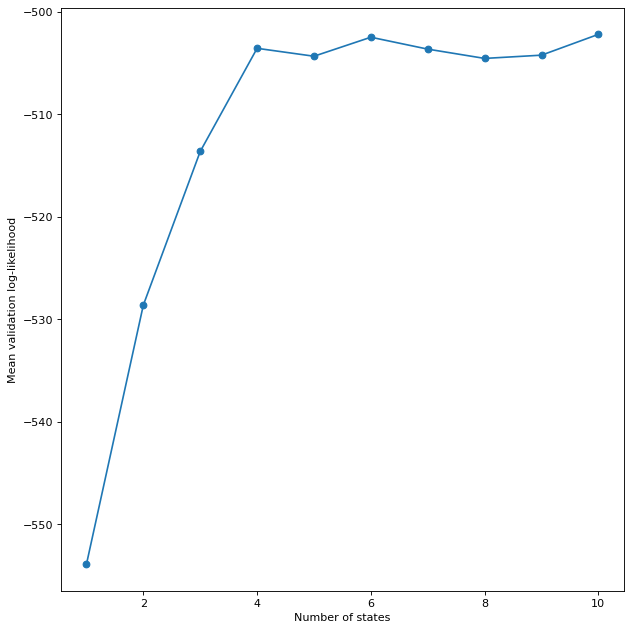

In [ ]:
# Plot cv_scores_dict
fig, ax = plt.subplots(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

ax.plot(list(cv_scores_dict.keys()), list(cv_scores_dict.values()), 'o-')
ax.set_xlabel("Number of states")
ax.set_ylabel("Mean validation log-likelihood")
plt.tight_layout()
plt.show()

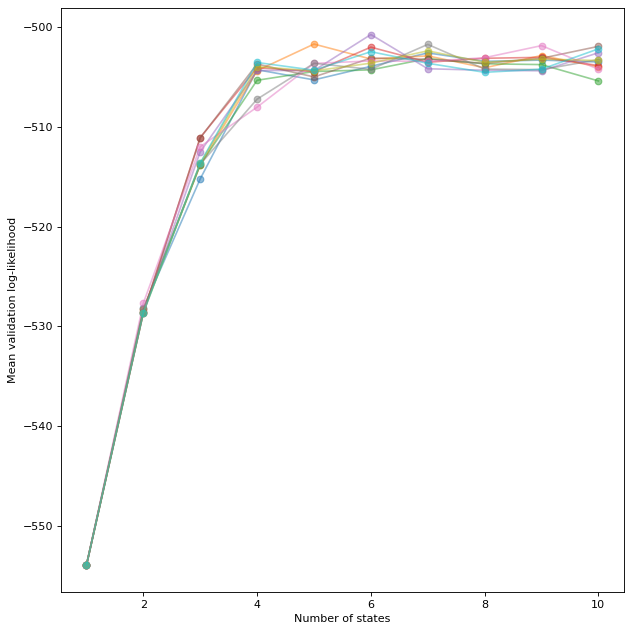

In [ ]:
# plot all cv_scores in cv_scores_concat

fig, ax = plt.subplots(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

for n_iter in range(n_iters):
    ax.plot(list(cv_scores_concat[n_iter].keys()), list(cv_scores_concat[n_iter].values()), 'o-', alpha=0.5)

ax.set_xlabel("Number of states")
ax.set_ylabel("Mean validation log-likelihood")
plt.tight_layout()
plt.show()

In [ ]:
type(hmm_glm)

ssm.hmm.HMM

In [ ]:
hmm_glm.log_likelihood

<bound method ensure_args_are_lists.<locals>.wrapper of <ssm.hmm.HMM object at 0x29a9e1a80>>

In [ ]:
inpts, true_choices, animal_df = format_data_hmmglm(valid_df, 'QP032', input_dim = input_dim)

In [ ]:
# Set the parameters of the GLM-HMM
num_states = 8       # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

hmm_glm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 1000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = hmm_glm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)
ll = hmm_glm.log_likelihood(true_choices, inputs=inpts)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# generate stimuli and choices using 2 state glm-hmm, then fit this data with states ranging from 1 to 10
npr.seed(0)

# Set the parameters of the GLM-HMM
num_states = 5        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_42442/4257390031.py:2: RuntimeWarning: divide by zero encountered in log
  gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01, 0, 0],


Text(0.5, 1.0, 'Generative transition matrix')

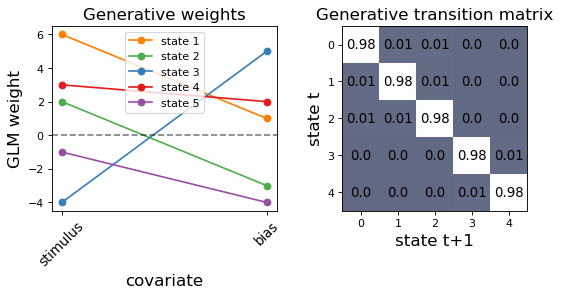

In [ ]:
gen_weights = np.array([[[6, 1]], [[2, -3]], [[-4, 5]], [[3, 2]], [[-1, -4]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01, 0, 0], 
                                      [0.01, 0.98, 0.01, 0, 0], 
                                      [0.01, 0.01, 0.98, 0, 0], 
                                      [0, 0, 0, 0.98, 0.01], 
                                      [0, 0, 0, 0.01, 0.98]]]))


# true_glmhmm.transitions.params = gen_log_trans_mat

# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c', '#984ea3', '#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
# plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
# plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)    
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [ ]:
num_sess = 10 # number of example sessions
num_trials_per_sess = 500 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

# Generate a sequence of latents and choices for each session
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

In [ ]:
# Calculate true loglikelihood
# true_ll = true_glmhmm.log_probability(true_choices, inputs=inpts) 
true_ll = true_glmhmm.log_likelihood(true_choices, inputs=inpts)
print("true ll = " + str(true_ll))

true ll = -3285.293662098962


In [ ]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
true_likelihood = true_glmhmm.log_likelihood(true_choices, inputs=inpts)
mle_final_ll = new_glmhmm.log_likelihood(true_choices, inputs=inpts) 

Text(0, 0.5, 'loglikelihood')

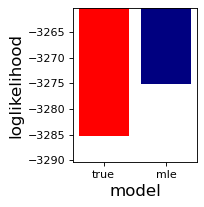

In [ ]:
# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [true_likelihood, mle_final_ll]
colors = ['Red', 'Navy']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((true_likelihood-5, true_likelihood+25))
plt.xticks([0, 1], ['true', 'mle'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

In [ ]:
mle_final_ll

-1339.7796554640436

In [ ]:
# # Define the range of numbers of states to evaluate and other constants
# n_states_range = range(1, 11)
# n_splits = 5
# N_iters = 200

# # Initialize a KFold object
# kf = KFold(n_splits)

# # Initialize the dictionary for storing cross-validation scores
# cv_scores = {}

# # Loop over the number of states to evaluate
# for n_states in n_states_range:
#     # Initialize the validation scores array
#     val_scores = np.zeros(n_splits)
    
#     # Iterate over the KFold splits
#     for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
#         # Efficiently split data for the current fold
#         x_train_fold, y_train_fold = [inpts[i] for i in train_indices], [true_choices[i] for i in train_indices]
#         x_val_fold, y_val_fold = [inpts[i] for i in val_indices], [true_choices[i] for i in val_indices]
        
#         # Initialize the HMM-GLM model for the current number of states
#         new_glmhmm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs", 
#                              observation_kwargs={"C": num_categories}, transitions="standard")
        
#         # Fit the model to the training data
#         new_glmhmm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=1e-4)
        
#         # Evaluate and store the log-likelihood of the validation data
#         val_scores[i_fold] = new_glmhmm.log_likelihood(y_val_fold, inputs=x_val_fold)
    
#     # Compute and store the mean validation score
#     cv_scores[n_states] = np.mean(val_scores)

# # Print the cross-validation scores
# for n_states, score in cv_scores.items():
#     print(f"n_states = {n_states}, CV score = {score}")

In [ ]:
# Plot the cross-validation scores against the number of states
fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(n_states_range, list(cv_scores.values()), 'o-')
plt.xlabel("Number of states")
plt.ylabel("Mean validation log-likelihood")
plt.tight_layout()
plt.show()


AttributeError: 'list' object has no attribute 'values'

<Figure size 640x640 with 0 Axes>

In [ ]:
# break execution here
raise Exception('Stop here')

Exception: Stop here

In [ ]:
# Define the range of numbers of states to evaluate and other constants
n_states_range = range(1, 11)
n_splits = 5
N_iters = 1000
kf = KFold(n_splits)

# Assuming inpts, true_choices, obs_dim, input_dim, and num_categories are defined elsewhere in your notebook

# Function to evaluate a single state count
def evaluate_state(n_states, inpts, true_choices, obs_dim, input_dim, num_categories):
    val_scores = np.zeros(n_splits)
    for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
        x_train_fold = [inpts[i] for i in train_indices]
        y_train_fold = [true_choices[i] for i in train_indices]
        x_val_fold = [inpts[i] for i in val_indices]
        y_val_fold = [true_choices[i] for i in val_indices]

        new_glmhmm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs",
                             observation_kwargs={"C": num_categories}, transitions="standard")
        new_glmhmm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=1e-4)

        val_scores[i_fold] = new_glmhmm.log_likelihood(y_val_fold, inputs=x_val_fold)

    return n_states, np.mean(val_scores)

# Parallel execution using joblib
cv_scores = Parallel(n_jobs=-1)(delayed(evaluate_state)(n_states, inpts, true_choices, obs_dim, input_dim, num_categories) for n_states in n_states_range)

# Convert list of tuples to dictionary
cv_scores_dict = {n_states: score for n_states, score in cv_scores}

# Print the cross-validation scores
for n_states, score in sorted(cv_scores_dict.items()):
    print(f"n_states = {n_states}, CV score = {score}")


LP: -2680.7:   0%|          | 0/1000 [00:00<?, ?it/s]

LP: -2746.2:  72%|███████▏  | 723/1000 [00:20<00:07, 38.69it/s]

n_states = 1, CV score = -668.7886807603177
n_states = 2, CV score = -658.0840605283844
n_states = 3, CV score = -658.8167244393297
n_states = 4, CV score = -659.7874798421559
n_states = 5, CV score = -659.9200962293912
n_states = 6, CV score = -659.4359653691674
n_states = 7, CV score = -659.8469618723313
n_states = 8, CV score = -660.4934118760127
n_states = 9, CV score = -660.9922566514327
n_states = 10, CV score = -660.4877511321821


Converged to LP: -2746.2:  73%|███████▎  | 731/1000 [00:20<00:07, 35.32it/s]


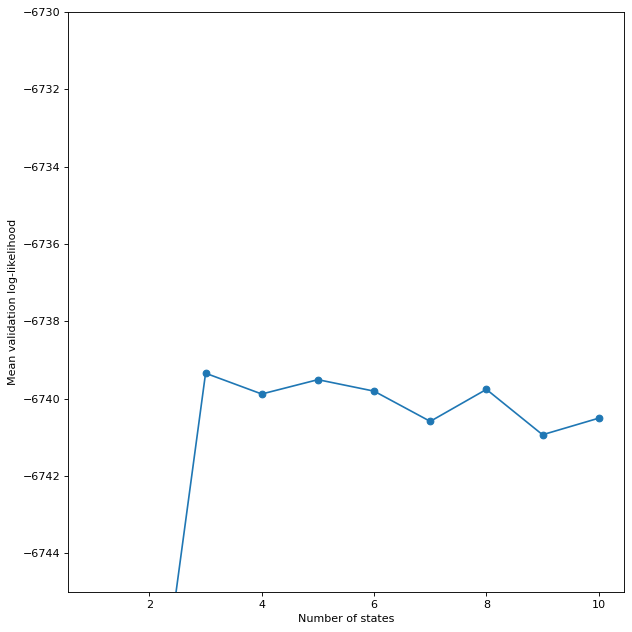

In [ ]:
# Plot cv_scores_dict
fig, ax = plt.subplots(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

ax.plot(list(cv_scores_dict.keys()), list(cv_scores_dict.values()), 'o-')
ax.set_xlabel("Number of states")
ax.set_ylabel("Mean validation log-likelihood")
plt.ylim(-6745, -6730)
plt.tight_layout()
plt.show()

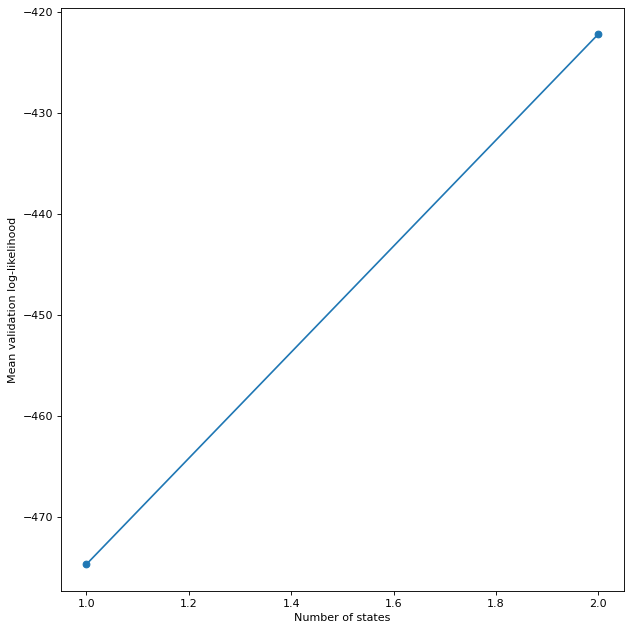

In [ ]:
# Plot cv_scores_dict
fig, ax = plt.subplots(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

ax.plot(list(cv_scores_dict.keys()), list(cv_scores_dict.values()), 'o-')
ax.set_xlabel("Number of states")
ax.set_ylabel("Mean validation log-likelihood")
plt.tight_layout()
plt.show()

## Single Participant Analysis

In [ ]:
# write a functions that return the proportion of rows that are Stim_Relative < 0 and Stim_Relative > 0
def get_prop_stim_rel(participant_df, stim_rel = 'Stim_Relative'):
    '''
    Get the proportion of rows that are Stim_Relative < 0 and Stim_Relative > 0
    Args:
        participant_df (pd.DataFrame): The dataframe to filter
        stim_rel (str): The column to filter on
    Returns:
        less_then_zero (float): The proportion of rows that are Stim_Relative < 0
        greater_then_zero (float): The proportion of rows that are Stim_Relative > 0
    '''

    less_then_zero = (participant_df[stim_rel] < 0).sum() / len(participant_df)
    greater_then_zero = (participant_df[stim_rel] > 0).sum() / len(participant_df)
    
    return less_then_zero, greater_then_zero

def run_binomial_test(df, p=0.5, alternative='two-sided', stim_rel = 'Stim_Relative'):
    '''
    Run a binomial test to check if the balance of trials presented on the left and right side is significantly different from 50/50
    Args:
        df (pd.DataFrame): The dataframe to filter
        p (float): The proportion of trials to test against
        alternative (str): The alternative hypothesis, either 'two-sided', 'greater', or 'less'
        stim_rel (str): The column to filter on
    Returns:
        p_value (float): The p-value of the binomial test
    '''

    # get number of trials presented on the left in block_df
    left_trials = df[df[stim_rel] < 0].shape[0]
    # get total number of trials in block_df
    total_trials = df.shape[0]
    result = binomtest(left_trials, total_trials, p=p, alternative=alternative)
    p_value = round(result.pvalue, 5)
    return p_value

In [ ]:
# Color dictionary for plots
color_dict = {'prop_correct': 'green', 'prop_incorrect': 'red', 'prop_no_response': 'k'}
step_size = 0.25
min_value = -0.875
# Function to calculate y-axis position for a given value
def calculate_y_position(value):
    return (value - min_value) / step_size
# Calculate y-axis positions for -1, 0, and 1
y_positions = [calculate_y_position(v) for v in [-1, 0, 1]]

In [ ]:
sub_df = sub_df.assign(
    Correct=lambda x: (x['Trial_Outcome'] == 'Correct').astype(int),
    Incorrect=lambda x: (x['Trial_Outcome'] == 'Incorrect').astype(int),
    No_Response=lambda x: (x['Trial_Outcome'] == 'No_Response').astype(int),
)

In [ ]:
for p_id in Animal_List:
    print(f'Processing participant {p_id}')
# for p_id in p_ids:
    save_path = figs_path + p_id + '_Choice_Behavior.pdf'
    participant_df = sub_df[sub_df['Participant_ID'] == p_id]
    with PdfPages(save_path) as pdf:

        for block in participant_df['block'].unique():
        # only select last 5 blocks
        # for block in participant_df['block'].unique()[-10:]:

            # Create a figure with two rows for the two sets of plots
            fig, axs = plt.subplots(2, 2, figsize=(22, 14), gridspec_kw={'width_ratios': [3, 1]}) 

            block_df = participant_df[participant_df['block'] == block]
            block_df = block_df.reset_index(drop=True)
            binomial_p_value = run_binomial_test(block_df, p=0.5, alternative='two-sided', stim_rel = 'Stim_Relative')
            if binomial_p_value > 0.05:
                L_R_ratio = 'Balanced'
            else:
                L_R_ratio = 'Unbalanced'
            
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]

            correct_mask = block_df['correct'] == 1
            incorrect_mask = block_df['Incorrect'] == 1
            no_response_mask = block_df['No_response'] == 1

            ax1.scatter(block_df[correct_mask]['Trial'], block_df[correct_mask]['stim_relative_binned'], 
                        color='green', marker='o', label='Correct', alpha=0.5)
            ax1.scatter(block_df[incorrect_mask]['Trial'], block_df[incorrect_mask]['stim_relative_binned'], 
                        color='red', marker='^', label='Incorrect', alpha=0.5)
            ax1.scatter(block_df[no_response_mask]['Trial'], block_df[no_response_mask]['stim_relative_binned'], 
                        color='black', marker='x', label='No Response', alpha=0.5)
            ax1.set_yticks([-1, 0, 1])
            ax1.set_yticklabels(['-1', '0', '1'])
            ax1.set_ylim(-1, 1)
            ax1.set_xlabel('Trial')
            ax1.set_ylabel('Distance from Boundary')

            grouped_by_stim_rel = block_df[['stim_relative_binned', 'correct', 'Incorrect', 'No_Response']] \
                                    .groupby('stim_relative_binned').sum()
            grouped_by_stim_rel['total'] = grouped_by_stim_rel.sum(axis=1)
            grouped_by_stim_rel['prop_correct'] = grouped_by_stim_rel['correct'] / grouped_by_stim_rel['total']
            grouped_by_stim_rel['prop_incorrect'] = grouped_by_stim_rel['Incorrect'] / grouped_by_stim_rel['total']
            grouped_by_stim_rel['prop_no_response'] = grouped_by_stim_rel['No_Response'] / grouped_by_stim_rel['total']
            grouped_by_stim_rel = grouped_by_stim_rel[['prop_correct', 'prop_incorrect', 'prop_no_response']] 
            grouped_by_stim_rel.plot(kind='barh', stacked=True, ax=ax2, width=1, color=[color_dict.get(x) for x in grouped_by_stim_rel.columns], alpha=0.5, legend=False)

            below_above_proportions = get_prop_stim_rel(block_df, stim_rel = 'Stim_Relative')

            ax2.set_xlabel('Proportions')
            ax2.set_ylabel(' ')
            ax2.set_xticks(np.arange(0, 1.1, 0.5))
            ax2.set_yticks(y_positions)
            ax2.set_yticklabels([-1, 0, 1], rotation=0)

        # ----------------------- Plot 2 (Row 2) -----------------------
            valid_block_df = block_df[block_df['No_response'] == 0].reset_index(drop=True)

            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            correct_mask = valid_block_df['correct'] == 1
            incorrect_mask = valid_block_df['Incorrect'] == 1

            ax3.scatter(valid_block_df[correct_mask]['Trial'], valid_block_df[correct_mask]['stim_relative_binned'],
                        color='green', marker='o', label='Correct', alpha=0.5)
            ax3.scatter(valid_block_df[incorrect_mask]['Trial'], valid_block_df[incorrect_mask]['stim_relative_binned'],
                        color='red', marker='^', label='Incorrect', alpha=0.5)
            ax3.set_yticks([-1, 0, 1])
            ax3.set_yticklabels(['-1', '0', '1'])
            ax3.set_ylim(-1, 1)
            ax3.set_xlabel('Trial')
            ax3.set_ylabel('Distance from Boundary')

            grouped_by_stim_rel_valid = valid_block_df[['stim_relative_binned', 'correct', 'Incorrect']] \
                                    .groupby('stim_relative_binned').sum()
            grouped_by_stim_rel_valid['total'] = grouped_by_stim_rel_valid.sum(axis=1)
            grouped_by_stim_rel_valid['prop_correct'] = grouped_by_stim_rel_valid['correct'] / grouped_by_stim_rel_valid['total']
            grouped_by_stim_rel_valid['prop_incorrect'] = grouped_by_stim_rel_valid['Incorrect'] / grouped_by_stim_rel_valid['total']
            grouped_by_stim_rel_valid = grouped_by_stim_rel_valid[['prop_correct', 'prop_incorrect']] 
            try:
                grouped_by_stim_rel_valid.plot(kind='barh', stacked=True, ax=ax4, width=1, color=[color_dict.get(x) for x in grouped_by_stim_rel_valid.columns], 
                                            alpha=0.5, legend=False)
            except:
                pass
            
            ax4.set_xlabel('Proportions')
            ax4.set_ylabel(' ')
            ax4.set_xticks(np.arange(0, 1.1, 0.5))
            ax4.set_yticks(y_positions)
            ax4.set_yticklabels([-1, 0, 1], rotation=0)

            params = {
                'Parameter': ['Participant', 'Date', 'Block', 'Distribution', 'AntiBias', 'Prop Stim Rel < 0', 
                              'Prop Stim Rel > 0', 'Left/Right Ratio', 'Opto'],
                'Value': [p_id, block_df['Datetime'].iloc[0].strftime('%Y/%m/%d'), block, block_df['Distribution'].iloc[0], 
                          block_df['Anti_Bias'].iloc[0], round(below_above_proportions[0], 2), round(below_above_proportions[1], 2), 
                          L_R_ratio, block_df['Opto_On'].iloc[0]]
            }
            params_df = pd.DataFrame(params)
            table = ax1.table(cellText=params_df.values, colLabels=params_df.columns, cellLoc = 'center', loc='top', bbox=[0, 1.1, 1, 0.5])
            # Set font to Arial and make headers bold
            for key, cell in table.get_celld().items():
                if key[0] == 0:  # Column headers are in the first row
                    cell.set_fontsize(12)
                    cell.get_text().set_fontname('Arial')
                    cell.get_text().set_weight('bold')

            plt.tight_layout()
            pdf.savefig()
            plt.close()

Processing participant QP032


Processing participant QP033
Processing participant QP034
Processing participant QP049
Processing participant QP050
Processing participant QP051


In [ ]:
# send sub_df to the frontend as a csv
# sub_df.to_csv('/Users/quentin/Desktop/sub_df.csv', index=False)

In [ ]:
# break execution here
raise Exception('Stop here')

Exception: Stop here

In [ ]:
# read the current Mouse_Data to see basic structure
data_path = '/Users/quentin/Desktop/sound-categorization/data/mouse/Data_Sound_Cat.csv'
original_df = pd.read_csv(data_path)

/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_49419/408329411.py:3: DtypeWarning: Columns (13,19,22,23,24,27) have mixed types. Specify dtype option on import or set low_memory=False.
  original_df = pd.read_csv(data_path)
